# To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  

In [1]:
import numpy as np
import pandas as pd
import ast
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sb
import pingouin as pg
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

# DATAFRAME SETUP AND FUNCTIONS
___

In [2]:
plt.rcParams['font.size'] = '30'

In [3]:
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

ID_list = ['s09', 's20', 's175', 's176', 's178', 's180', 's181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212', 's217', 's219', 's224', 's240',
           's254', 's261', 's262', 's263', 's267', 's276', 's278', 's279', 's282', 's283', 's286']

len(ID_list)


## having too many subjects breaks the figure code, just look at the ones of interest for now. 

31

In [4]:
## making one trial based dataframe using data from all participants
all_maindfs = glob.glob("subject_data/main_dfs/*.csv")
all_trials = (pd.concat((pd.read_csv(f) for f in all_maindfs))).reset_index(drop=True)
# print(all_trials)

## making dataframe of only rts from all trials
all_rts = typ.rt_columns(all_trials)

## adding ikis to main dataframe using all_rts
all_trials = pd.concat([all_trials, typ.iki(all_rts).iloc[:,1:7]], axis = 1)
all_trials = all_trials.rename(columns={0: 'iki_1', 1: 'iki_2', 2: 'iki_3', 3: 'iki_4', 4: 'iki_5', 5: 'iki_6'})
all_trials = all_trials.drop(columns=['Unnamed: 0'])

## making one trial based dataframe using data from all participants
all_bigramdfs = glob.glob("subject_data/bigram_dfs/*.csv")
all_bigrams = (pd.concat((pd.read_csv(f) for f in all_bigramdfs))).reset_index(drop=True)
all_bigrams['Bigram'] = all_bigrams['Bigram'].apply(lambda x: (x.replace("'", "")).replace(" ", ""))
all_bigrams = all_bigrams.rename(columns = {'Trial #': 'trial', 'bigram #': 'bigram_num', 'Bigram': 'bigram'})
all_bigrams = all_bigrams.drop(columns=['Unnamed: 0'])

## making filtered dataframes by errors
corr_trials = (all_trials[all_trials.string == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = typ.correct_filter(all_bigrams) ## excludes all bigrams in an error trial
incorr_trials_bybg = typ.incorrect_filter(all_bigrams)

corr_bgs = (all_bigrams[all_bigrams.bigram == all_bigrams.corr_bigram]).reset_index(drop=True) ## excludes only incorrect bigrams 
incorr_bgs = (all_bigrams[all_bigrams.bigram != all_bigrams.corr_bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.iloc[:, 24:28]: ## depends on position of iki columns
        avg_iki = sub_df[col].mean()
        sd_iki = sub_df[col].std()
        sub_df = sub_df.loc[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])
    
## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
## making dataframe with both correct and incorrect bigrams that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [5]:
all_bigrams.to_csv('all_bigrams.csv')
# all_bigrams['corr_bigram'].unique()
filtered = all_bigrams[(all_bigrams.IKI > 2)]
filtered

# all_bigrams[[type(x) != str for x in list(all_bigrams.corr_bigram)]]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(all_bigrams)

sID  Bigram #  trial  bigram_loc bigram corr_bigram       IKI string  \
9091   s178       398     98           2     th          th  2.271981  tithe   
9097   s178       404    100           0     ed          ed  2.304000  edthe   
9108   s178       415    102           3     re          re  2.103872  there   
9142   s178       449    111           1     qa          aq  2.376052  faqir   
21692  s276       478    119           1     ol          ao  2.136233  haole   
25913  s189       852    212           1     qr          aq  2.247893  faqir   

      resp_string  rep #     bg_freq bf_type meanbf_type wf_type  
9091        ththe      4  22288309.0    high        high     low  
9097        edthe      4   7805967.0    high        high  pseudo  
9108        there      4  10687711.0    high        high    high  
9142         fqai      3      4924.0     low         low     low  
21692        hole      4     25487.0     low         med     low  
25913        fqri      8      4924.0     low         low     low

In [6]:
## defining functions that calculate individual IKI means and CVs for a particular bigram in a defined string
##### these need to be edited to include changable dataframe like the other functions

def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
    # means.columns = ['Avg IKI']
    return means

def indiv_avgcvs(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
    # avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

def indiv_avgsds(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg SD IKI'})
    # avg_sds.columns = ['Avg SD IKI']
    return avg_sds

def indiv_error(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('please write "string" or "bigram"for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size()).reset_index().rename(columns = {0:'Total Error'})
    for ID in dataframe.sID.unique():
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    return errs

In [7]:
## Making dataframe of IKI stats
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [8]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['corr_bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['corr_bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['corr_bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [9]:
## making lists of bigrams without bigrams with repeated letters
med_reps = ['ll', 'ee', 'oo', 'pp']    
medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

typ.lowbf
low_reps = ['dd', 'kk']
lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

# STATS
___

In [10]:
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
low_iki['bf_type'] = 'low'

print(stat.stdev(high_iki['Avg IKI']))
print(stat.stdev(med_iki['Avg IKI']))
print(stat.stdev(low_iki['Avg IKI']))

0.03304000802638131
0.03513555563926756
0.04160690224668977


In [11]:
## anova for means (by bg freq)
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     54  141.34945  3.460236e-22  0.323238  0.702222


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.141251  0.202221 -0.060970  0.009829 -6.203297  6.618284e-08   
1  high  med  0.141251  0.167866 -0.026615  0.009829 -2.707919  2.225662e-02   
2   low  med  0.202221  0.167866  0.034355  0.009829  3.495378  2.202686e-03   

      cohen  
0 -1.622902  
1 -0.780414  
2  0.892160

In [12]:
## anova for means (by avg bg freq)
high_iki = indiv_means(corr_trials_bybg, 'string', typ.high_avgbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'string', typ.med_avgbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'string', typ.low_avgbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc       ng2       eps
0  bf_type      2     54  187.867328  4.766738e-25  0.366465  0.717189


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.142455  0.206158 -0.063703  0.009701 -6.566663  1.366487e-08   
1  high  med  0.142455  0.158074 -0.015620  0.009701 -1.610099  2.472407e-01   
2   low  med  0.206158  0.158074  0.048084  0.009701  4.956565  1.148565e-05   

      cohen  
0 -1.710176  
1 -0.480715  
2  1.237677

In [13]:
## anova for means (by word freq)
# only_onebf = corr_trials_bybg[corr_trials_bybg.bf_type == 'low']

high_iki = indiv_means(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_means(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3     81  27.929268  1.684422e-12  0.088872  0.809289


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.153827  0.178721 -0.024894  0.009772 -2.547384  0.058389   
1  high     med  0.153827  0.161846 -0.008019  0.009772 -0.820544  0.844639   
2  high  pseudo  0.153827  0.180294 -0.026466  0.009772 -2.708292  0.038777   
3   low     med  0.178721  0.161846  0.016875  0.009772  1.726840  0.314910   
4   low  pseudo  0.178721  0.180294 -0.001572  0.009772 -0.160908  0.998508   
5   med  pseudo  0.161846  0.180294 -0.018448  0.009772 -1.887748  0.239380   

      cohen  
0 -0.708734  
1 -0.235729  
2 -0.677347  
3  0.498227  
4 -0.040374  
5 -0.486101

In [14]:
## anova for cvs (by bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  bf_type      2     54  12.371628  0.000038  0.128965  0.780737


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.271781  0.260913  0.010869  0.015379  0.706741  0.760214   
1  high  med  0.271781  0.221195  0.050586  0.015379  3.289361  0.004203   
2   low  med  0.260913  0.221195  0.039718  0.015379  2.582620  0.030844   

      cohen  
0  0.175296  
1  0.857070  
2  0.778130

In [15]:
## anova for cvs (by avg bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.high_avgbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.med_avgbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.low_avgbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bf_type      2     54  8.535567  0.000601  0.077137  0.924233


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.370083  0.436029 -0.065946  0.025346 -2.601842  0.029362   
1  high  med  0.370083  0.403643 -0.033561  0.025346 -1.324112  0.386025   
2   low  med  0.436029  0.403643  0.032385  0.025346  1.277729  0.411784   

      cohen  
0 -0.723292  
1 -0.330472  
2  0.354295

In [16]:
## anova for cvs (by word freq)

high_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg CV IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg CV IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  wf_type      3     81  7.383589  0.000196  0.085998  0.783052


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.379976  0.402258 -0.022281  0.026841 -0.830120  0.840054   
1  high     med  0.379976  0.377815  0.002162  0.026841  0.080532  0.999812   
2  high  pseudo  0.379976  0.452957 -0.072981  0.026841 -2.719011  0.037702   
3   low     med  0.402258  0.377815  0.024443  0.026841  0.910652  0.799209   
4   low  pseudo  0.402258  0.452957 -0.050700  0.026841 -1.888891  0.238890   
5   med  pseudo  0.377815  0.452957 -0.075142  0.026841 -2.799543  0.030421   

      cohen  
0 -0.226913  
1  0.020703  
2 -0.691476  
3  0.257182  
4 -0.526557  
5 -0.732256

In [17]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     54  20.710072  2.110326e-07  0.195216  0.645403


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.044240  0.064591 -0.020351  0.005289 -3.848198  0.000685   
1  high  med  0.044240  0.044340 -0.000100  0.005289 -0.018954  0.999802   
2   low  med  0.064591  0.044340  0.020251  0.005289  3.829244  0.000731   

      cohen  
0 -0.973365  
1 -0.005564  
2  0.996458

In [18]:
## anova for sds (by avg bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.high_avgbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.med_avgbf)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.low_avgbf)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     54  44.798908  3.401261e-12  0.325921  0.779903


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.055454  0.095955 -0.040500  0.006712 -6.033665  1.369122e-07   
1  high  med  0.055454  0.066049 -0.010595  0.006712 -1.578370  2.607979e-01   
2   low  med  0.095955  0.066049  0.029906  0.006712  4.455295  7.836749e-05   

      cohen  
0 -1.518927  
1 -0.502077  
2  1.102243

In [19]:
## anova for sds (by word freq)

high_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg SD IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg SD IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3     81  14.882583  8.367085e-08  0.154695  0.820403


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.059716  0.078623 -0.018907  0.006913 -2.734819  0.036163   
1  high     med  0.059716  0.064632 -0.004916  0.006913 -0.711086  0.892509   
2  high  pseudo  0.059716  0.086974 -0.027258  0.006913 -3.942794  0.000816   
3   low     med  0.078623  0.064632  0.013991  0.006913  2.023733  0.185703   
4   low  pseudo  0.078623  0.086974 -0.008351  0.006913 -1.207974  0.623154   
5   med  pseudo  0.064632  0.086974 -0.022342  0.006913 -3.231707  0.008737   

      cohen  
0 -0.798050  
1 -0.213414  
2 -1.049438  
3  0.543109  
4 -0.293859  
5 -0.801527

In [20]:
## anova for error rates (by bg freq)
high_err = indiv_error(incorr_bgs, 'bigram', typ.highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_bgs, 'bigram', typ.medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_bgs, 'bigram', typ.lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  bf_type      2     54  1.061432  0.353066   0.343001  0.014076  0.822845   

   sphericity   W-spher   p-spher  
0       False  0.784704  0.042774  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  6.285714  6.035714  0.250000  1.267831  0.197187  0.978798   
1  high  med  6.285714  7.321429 -1.035714  1.267831 -0.816918  0.693674   
2   low  med  6.035714  7.321429 -1.285714  1.267831 -1.014106  0.570154   

      cohen  
0  0.050939  
1 -0.213414  
2 -0.288421

In [21]:
## anova for error rates (by avg bg freq)
high_err = indiv_error(incorr_trials, 'string', typ.high_avgbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_trials, 'string', typ.med_avgbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_trials, 'string', typ.low_avgbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  bf_type      2     54  2.544926  0.087858   0.099891  0.031408  0.814992   

   sphericity   W-spher  p-spher  
0       False  0.772994  0.03518  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  4.964286  6.642857 -1.678571  1.039561 -1.614692  0.245318   
1  high  med  4.964286  5.678571 -0.714286  1.039561 -0.687103  0.771673   
2   low  med  6.642857  5.678571  0.964286  1.039561  0.927589  0.624525   

      cohen  
0 -0.431970  
1 -0.202320  
2  0.228399

In [22]:
## running signed rank test
# wilcoxon()

# iki_ranks = (indiv_means(tight_bgs, 'bigram', typ.highbf).sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
# iki_ranks['rank'] = iki_ranks.index
# iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

# cv_ranks = (indiv_avgcvs(tight_bgs, 'bigram', typ.highbf).sort_values(by = 'Avg CV IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
# cv_ranks['rank'] = cv_ranks.index
# cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

# rank_diff = iki_ranks['rank'] - cv_ranks['rank']
# rank_diff

# wilcoxon(rank_diff)

# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

In [23]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')
skew_df

sID      skew  mean IKI
0    s09  2.188929  0.129063
1    s20  4.537099  0.135337
2   s175  2.812225  0.191252
3   s176       NaN       NaN
4   s178  9.766887  0.155502
5   s180  3.704217  0.132674
6   s181  4.930082  0.116986
7   s182  2.506407  0.169157
8   s183  4.123232  0.160179
9   s189  3.283803  0.173022
10  s190  2.493626  0.161795
11  s198  3.385264  0.160854
12  s207  2.572649  0.187600
13  s209  4.537099  0.135337
14  s210  3.535854  0.177614
15  s212  4.541527  0.173739
16  s217  2.012043  0.138689
17  s219  3.658609  0.248666
18  s224  5.852693  0.149656
19  s240       NaN       NaN
20  s254       NaN       NaN
21  s261  1.657398  0.137923
22  s262  7.257390  0.129549
23  s263  2.918295  0.182596
24  s267  2.525303  0.207722
25  s276  2.076324  0.170538
26  s278  4.843809  0.168783
27  s279  1.463701  0.240455
28  s282  2.383787  0.245906
29  s283  3.170107  0.157842
30  s286  2.911800  0.199737

# GRAPHS
___

## Data Visualization
___

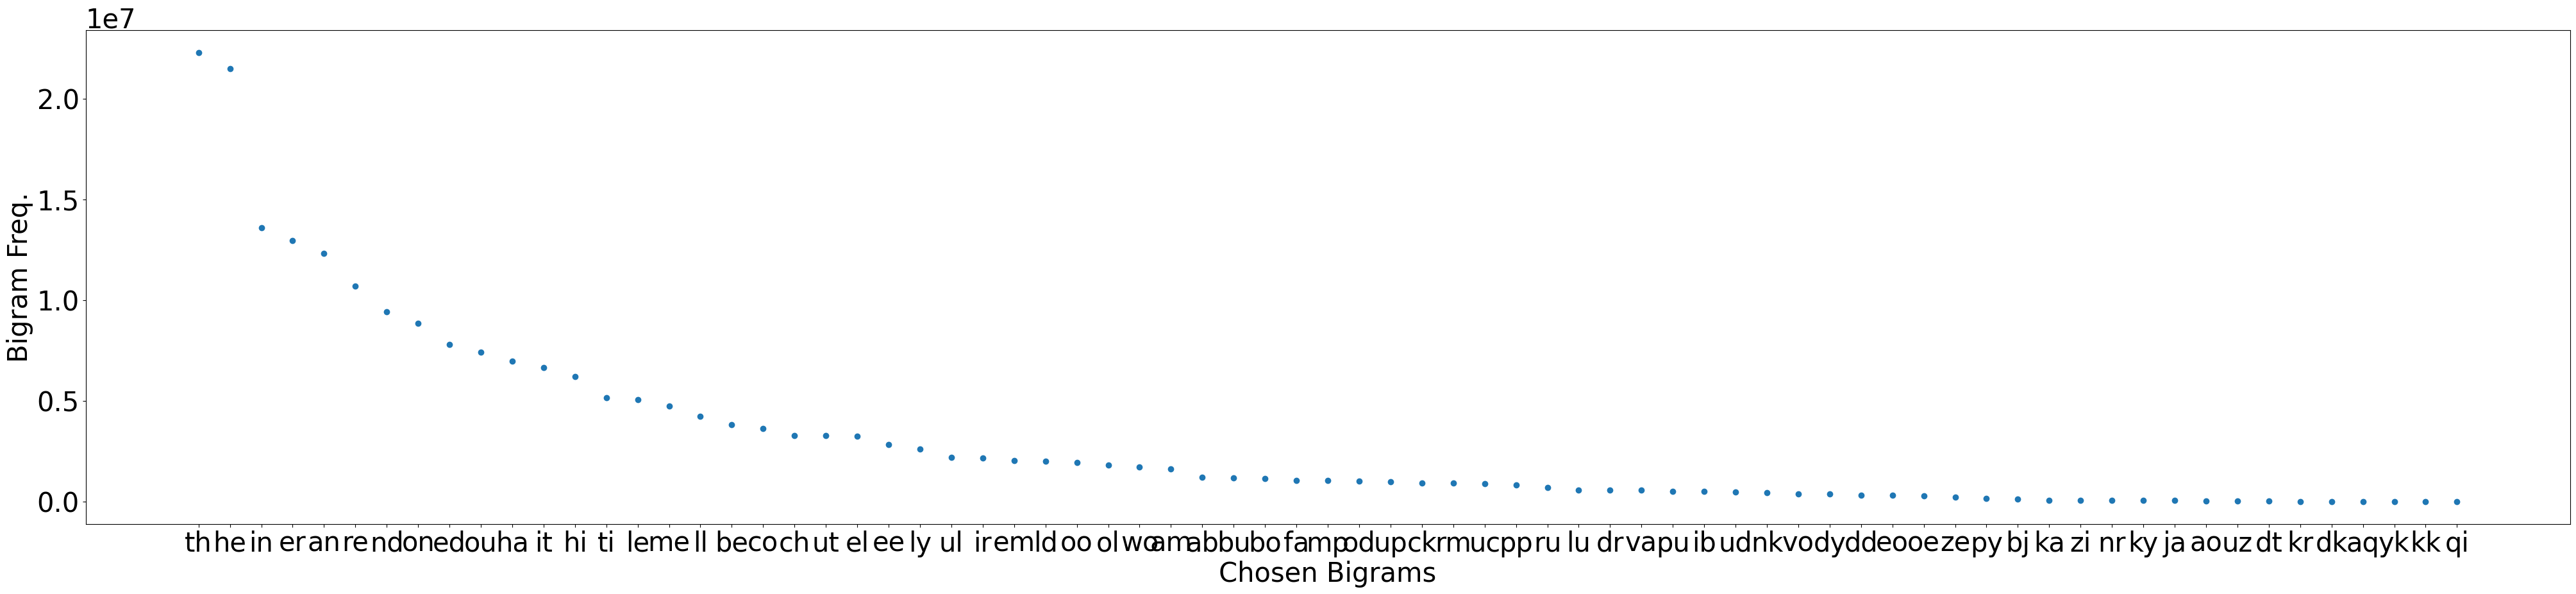

In [24]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

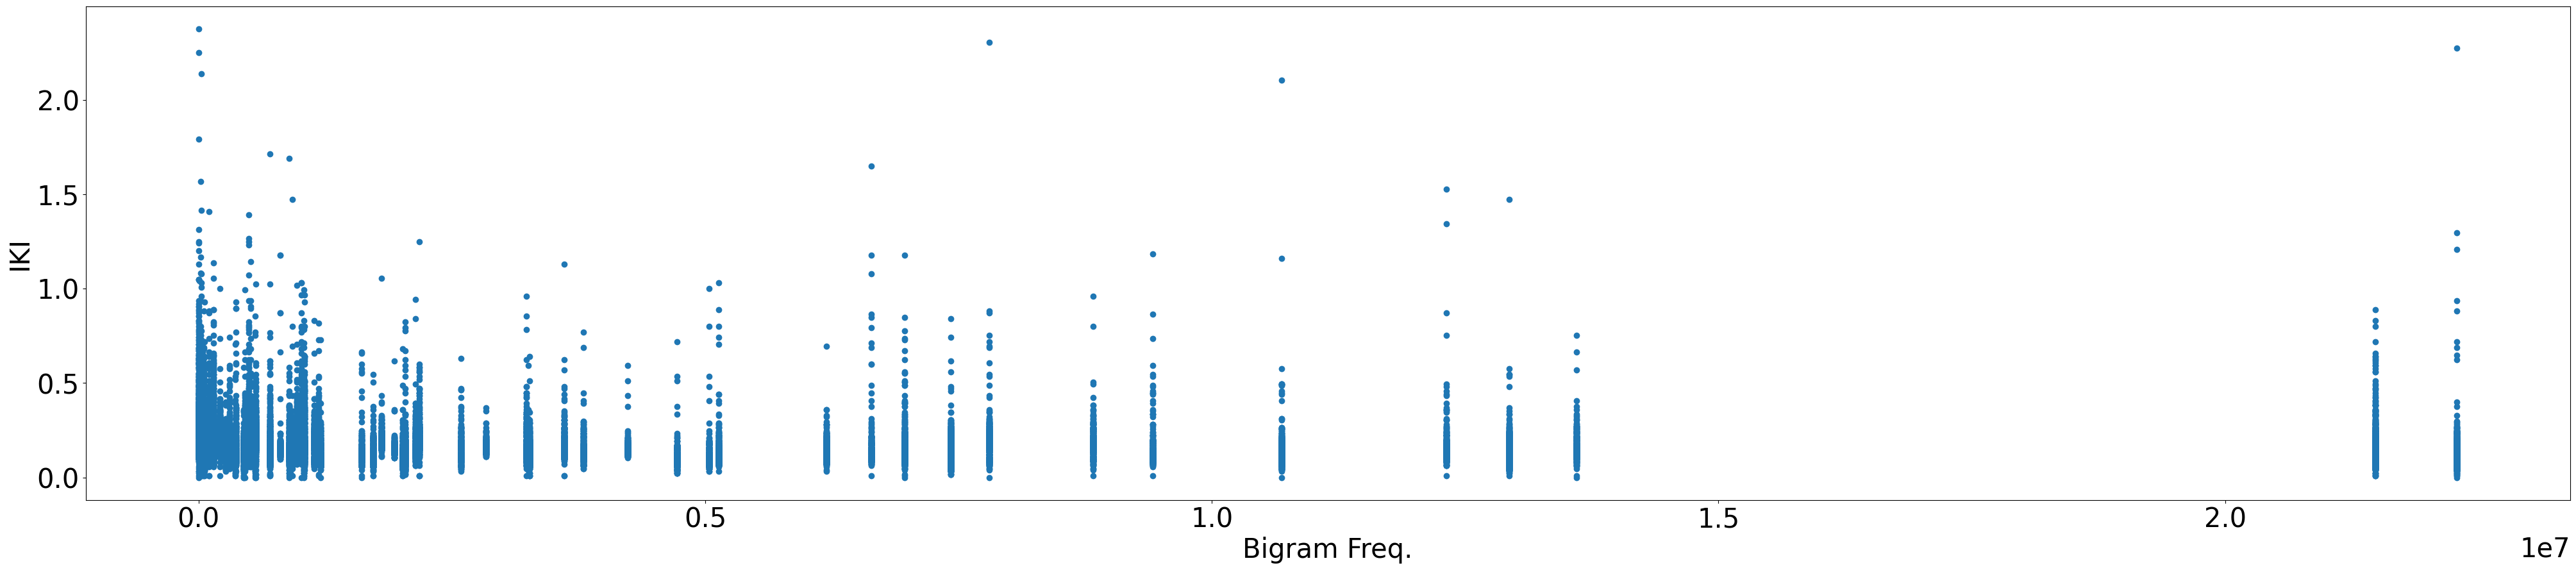

In [25]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

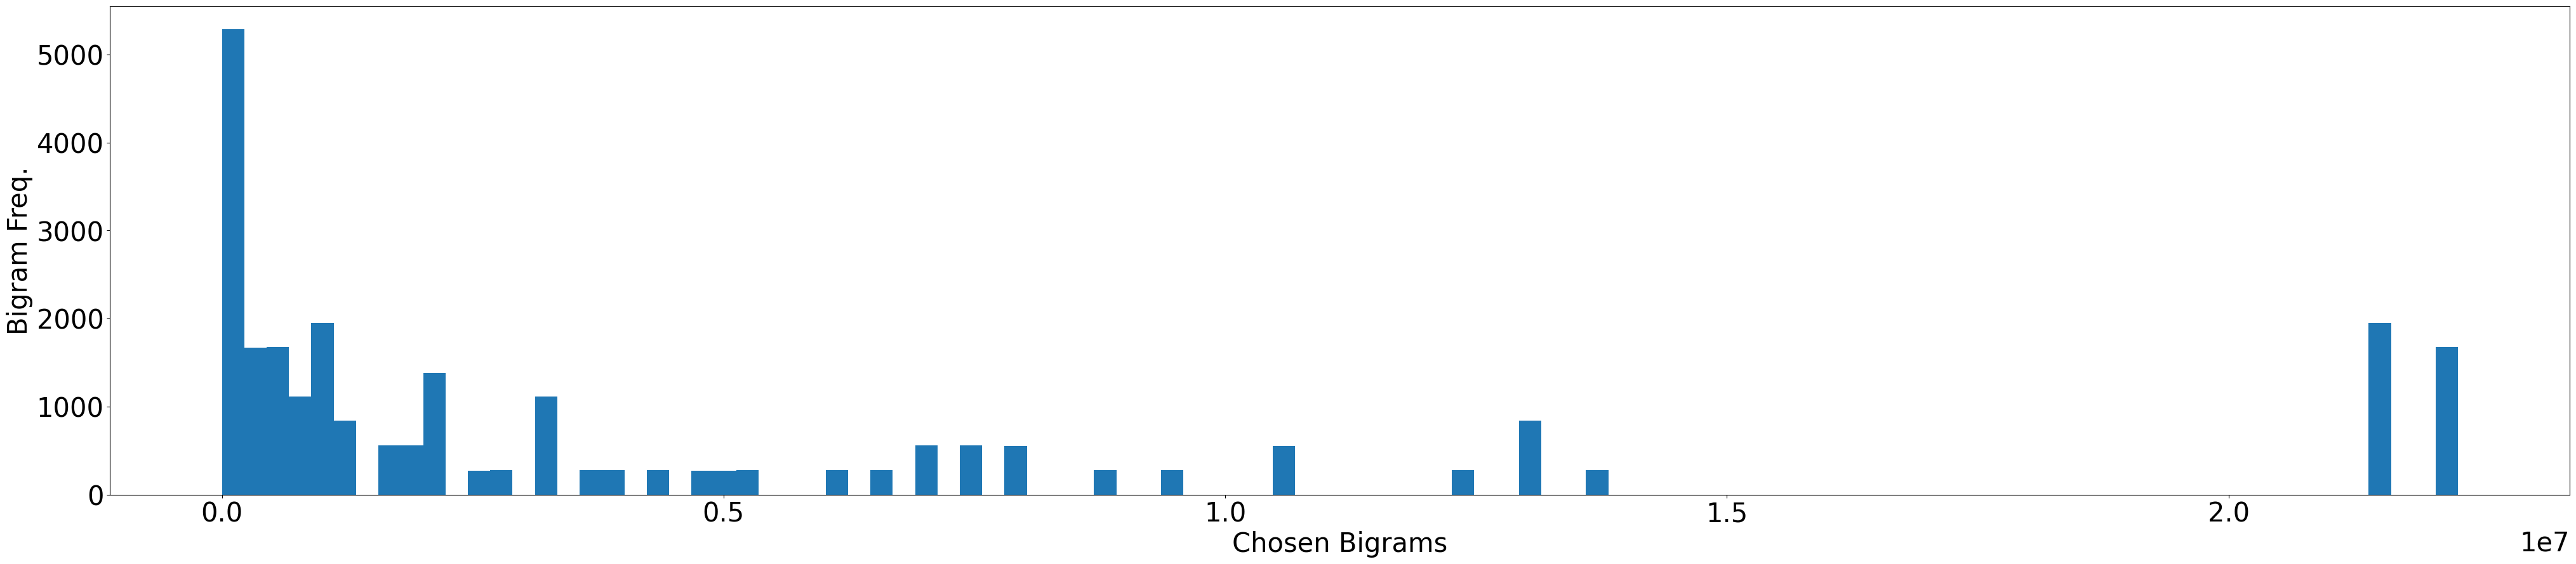

In [26]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

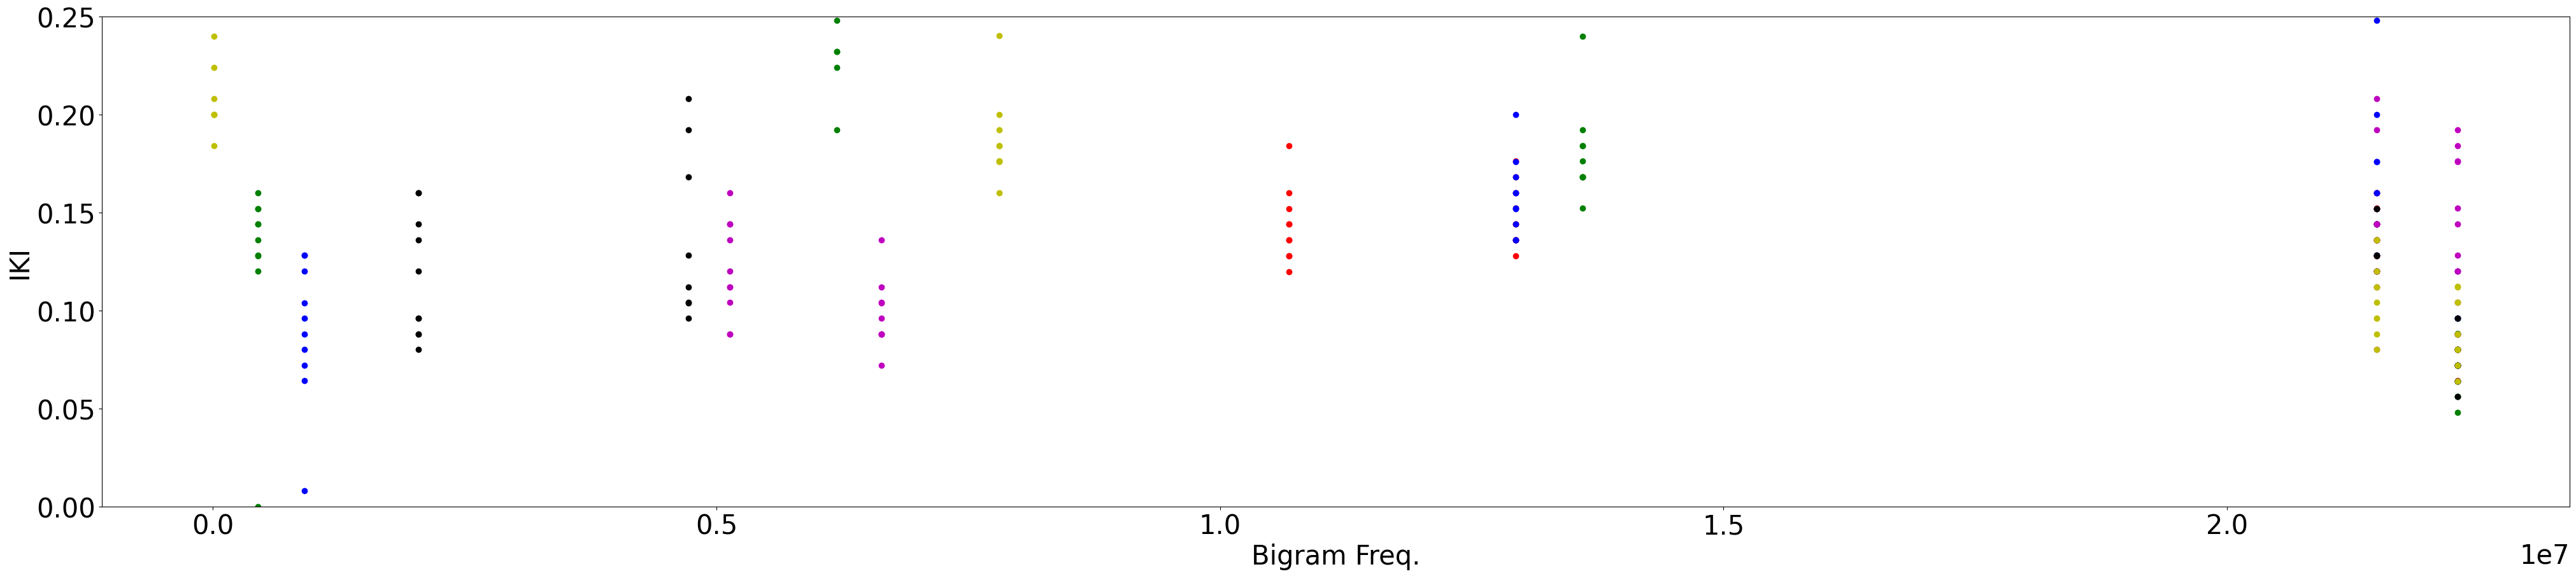

In [27]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sb.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

In [28]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['corr_bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['corr_bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['corr_bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

## Mean IKI GRAPHS
___

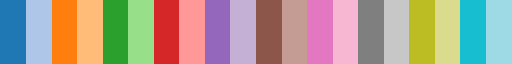

In [29]:
# plt.style.available
# plt.style.use('default')
plt.get_cmap('tab20')

In [30]:
# indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)

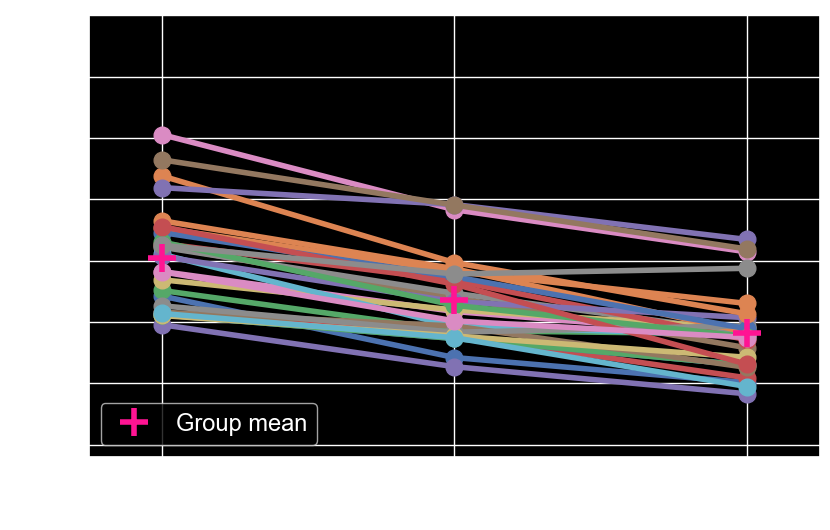

In [136]:
## individual IKI means by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

### Creates unique range of colors dependent on number of lines plotted -- useful if you plot more than 20 participants in one graph
## Current color map has 20 unique colors
# color = cm.rainbow(np.linspace(0, 1, len(ID_list)))
# for i, c in zip(range(len(ID_list)), color):
#     plt.plot(x, [l[i] for l in D], '.-', linewidth = 2.5, ms = 20, c = c)

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.04, 0.4])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

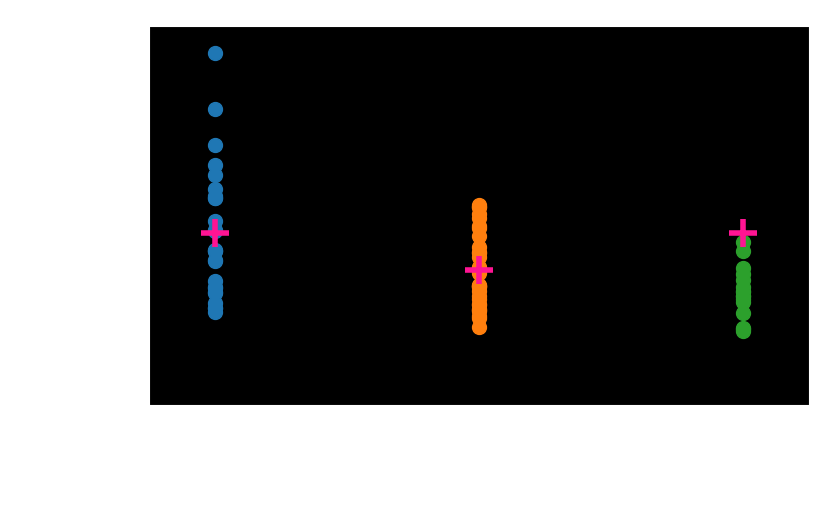

In [32]:
## bigram IKI means across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['Mean'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['Mean'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['Mean'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['Mean']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['Mean']),
         np.mean(bg_stats[bg_stats.bf_type == 'low']['Mean']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.04, 0.4])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Avg. IKIs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

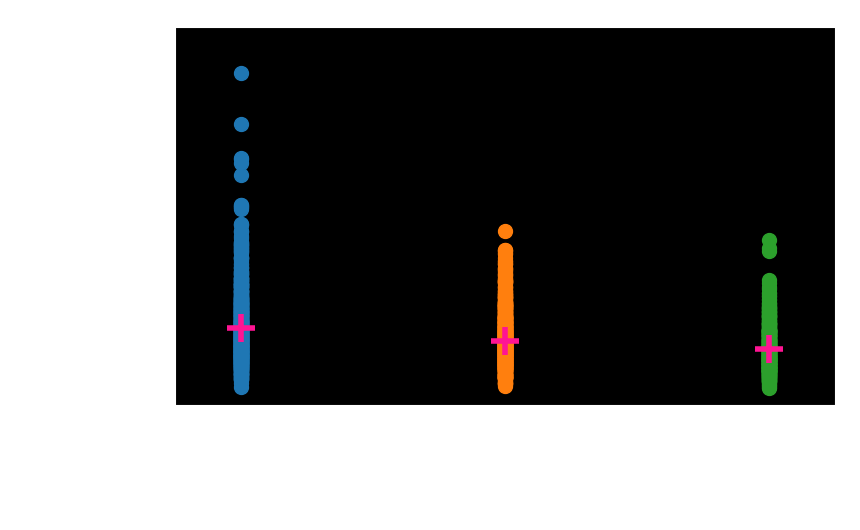

In [33]:
## all bigram IKI means for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

D2 = list(ikis[ikis.bf_type == 'Low']['mean'])
x2 = [2]*len(D2)


D4 = list(ikis[ikis.bf_type == 'Med']['mean'])
x4 = [4]*len(D4)

D6 = list(ikis[ikis.bf_type == 'High']['mean'])
x6 = [6]*len(D6)

means = (np.mean(ikis[ikis.bf_type == 'Low']['mean']),
         np.mean(ikis[ikis.bf_type == 'Med']['mean']),
         np.mean(ikis[ikis.bf_type == 'High']['mean']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 1])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Avg. IKIs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

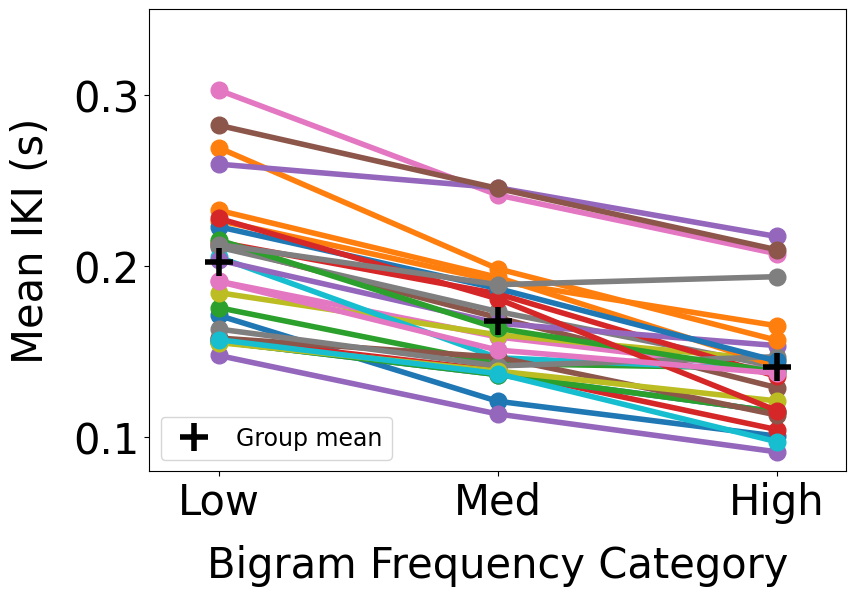

In [34]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

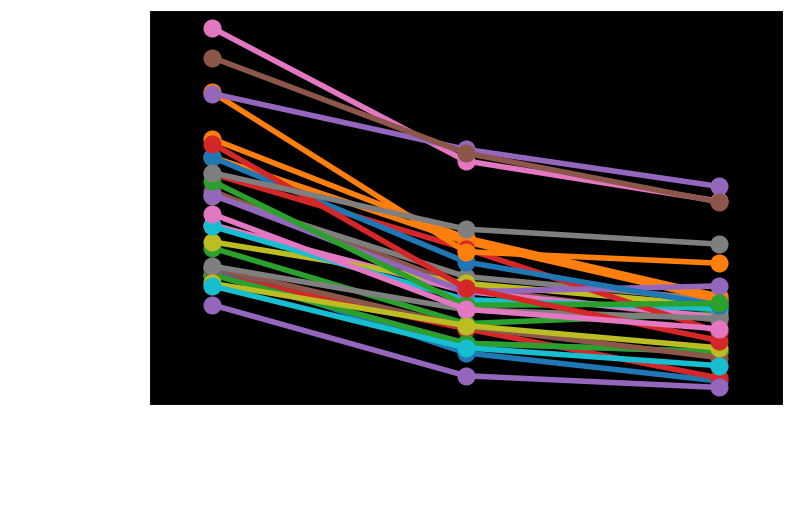

In [35]:
## individual IKI means by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'string', typ.low_avgbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.med_avgbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.high_avgbf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, transparent = True)
plt.show()

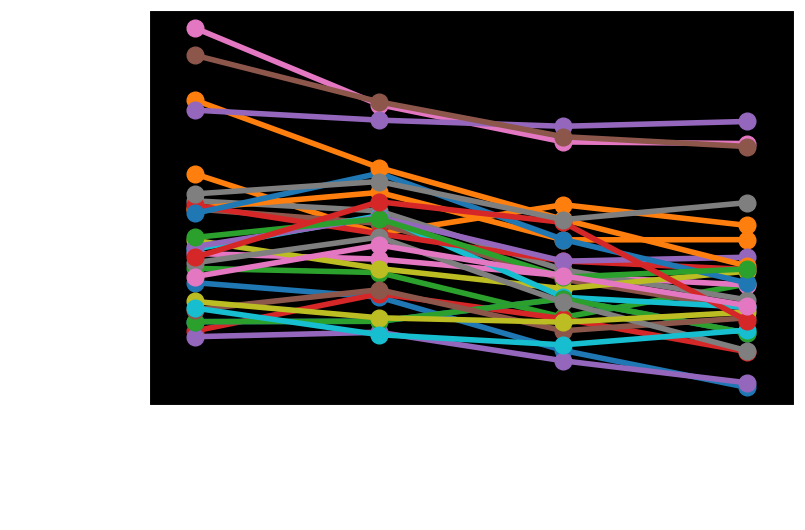

In [36]:
## individual IKI means by WF category
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6, 8]
D = (indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI'],
    indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

## CV GRAPHS
___

In [37]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_avgcvs(all_bigrams, 'bigram', typ.highbf),
    indiv_avgcvs(all_bigrams, 'bigram', typ.medbf).rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf).rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
# cv_df

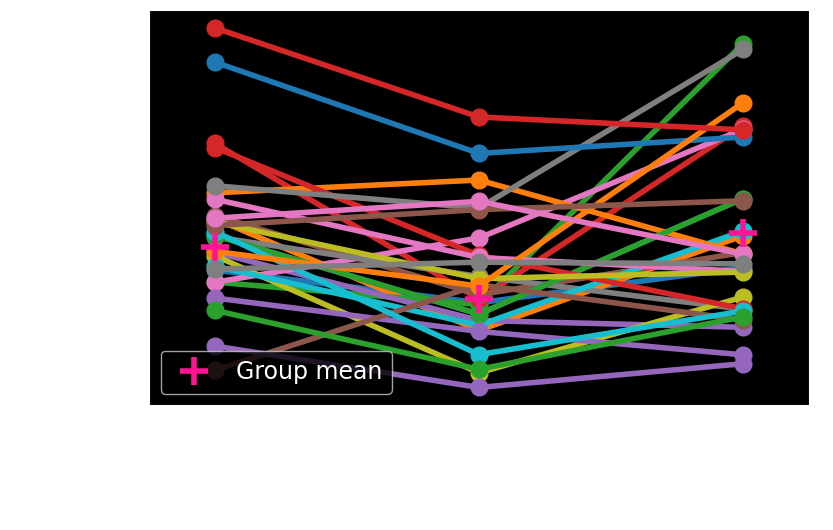

In [38]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', lowbf_norep)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', medbf_norep)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

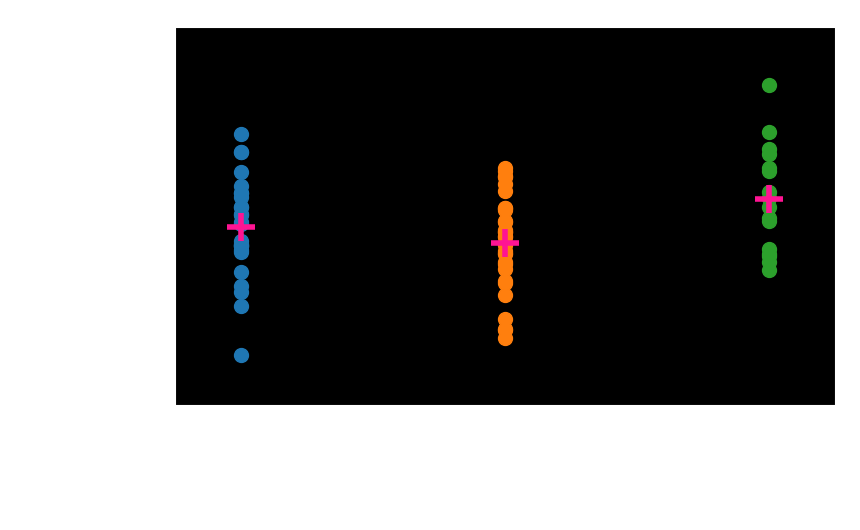

In [39]:
## bigram IKI CVs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['CV'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['CV'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['CV'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['CV']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 1])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

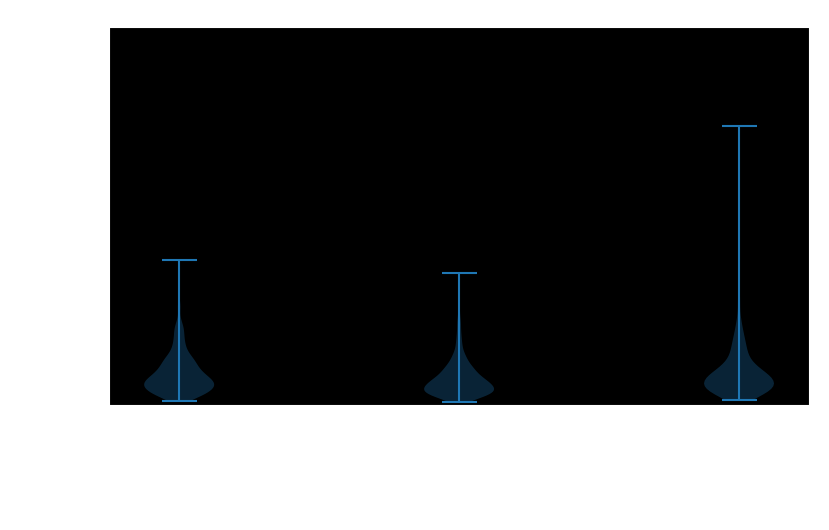

In [40]:
## all bigram IKI CVs for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

D2 = list(cvs[cvs.bf_type == 'Low']['variation'])
x2 = [2]*len(D2)


D4 = list(cvs[cvs.bf_type == 'Med']['variation'])
x4 = [4]*len(D4)

D6 = list(cvs[cvs.bf_type == 'High']['variation'])
x6 = [6]*len(D6)

means = (np.mean(cvs[cvs.bf_type == 'Low']['variation']),
         np.mean(cvs[cvs.bf_type == 'Med']['variation']),
         np.mean(cvs[cvs.bf_type == 'High']['variation']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.violinplot([D2, D4, D6], [2, 4, 6])

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 3])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

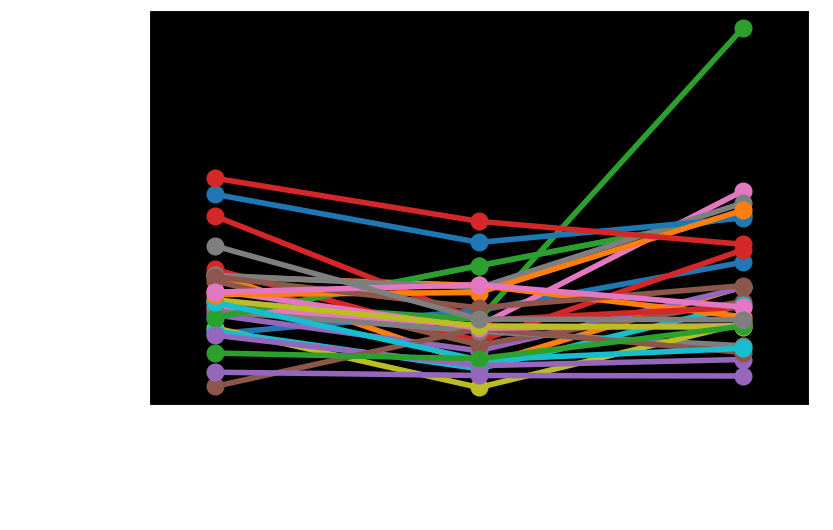

In [41]:
## Inividual MEAN CV IKIs by BF (all trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

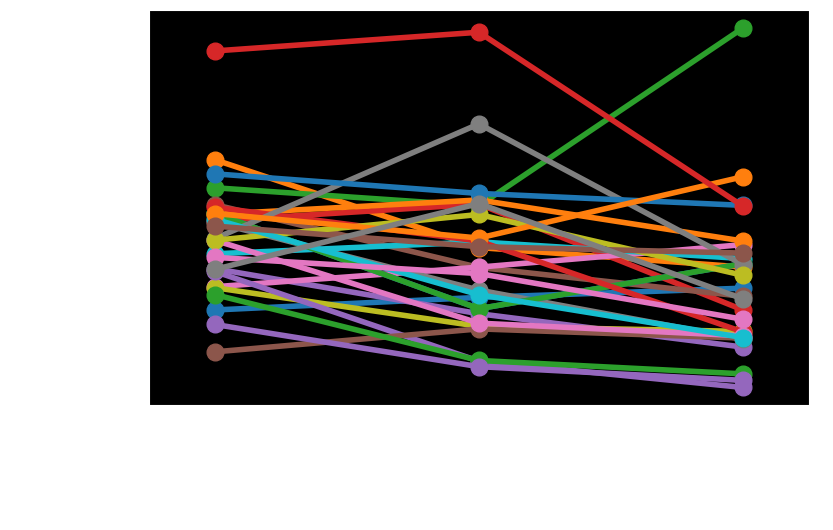

In [42]:
## Individual MEAN CV IKI by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'string', typ.low_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.med_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.high_avgbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_cvikis_bybf.png', dpi=300, transparent = True)
plt.show()

In [43]:
# individual MEAN CV IKIs by AVG BF category (tight_bgs df)
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# x = [2, 4, 6]
# D = (indiv_avgcvs(tight_bgs, 'string', typ.low_avgbf)['Avg CV IKI'], 
#      indiv_avgcvs(tight_bgs, 'string', typ.med_avgbf)['Avg CV IKI'], 
#      indiv_avgcvs(tight_bgs, 'string', typ.high_avgbf)['Avg CV IKI'])

# fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_mean_ikis.png', dpi=300)
# plt.show()

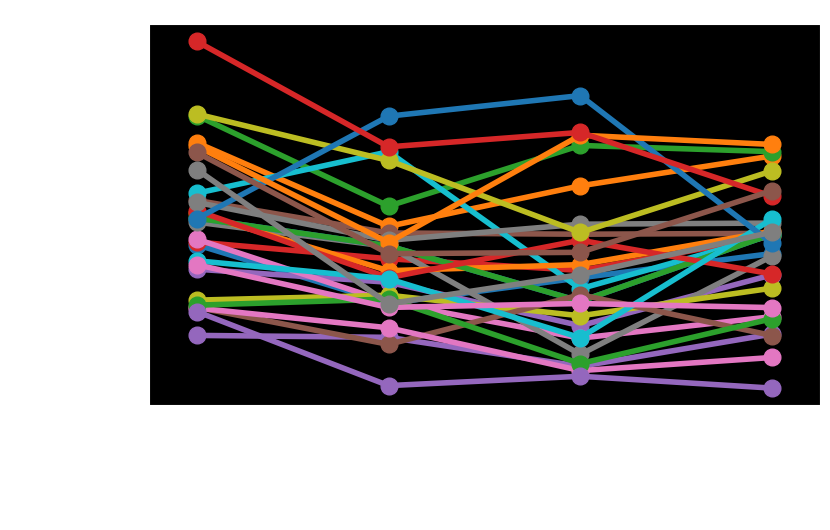

In [44]:
# individual avg CV IKI by WF category (can also change dataframe here)
x = [2, 4, 6, 8]
D = (indiv_avgcvs(tight_bgs, 'string', typ.pseudo)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medwf)['Avg CV IKI'],
     indiv_avgcvs(tight_bgs, 'string', typ.highwf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

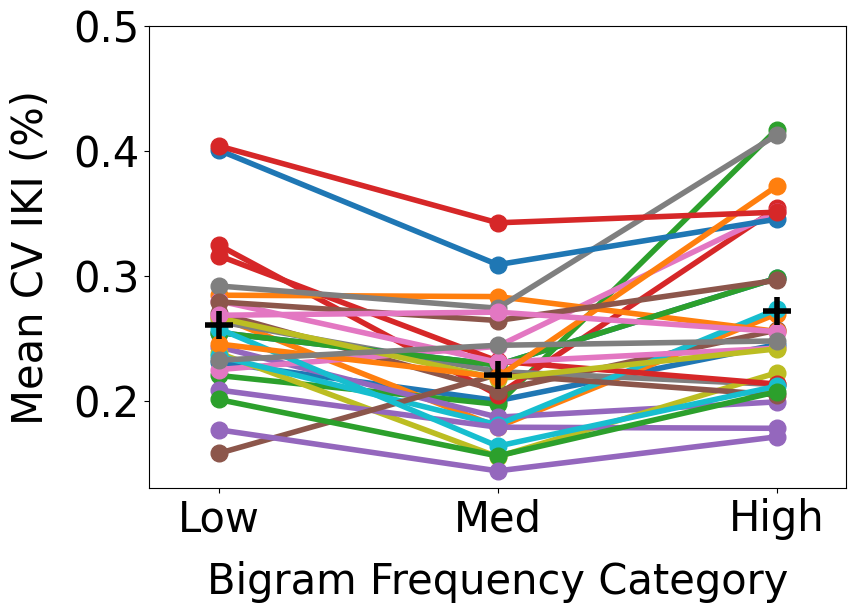

In [45]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## SD GRAPHS
___

In [46]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     # print(typ.all_bigrams)
    
# repeats = ['ll', 'oo', 'pp', 'dd', 'kk']

# noreps

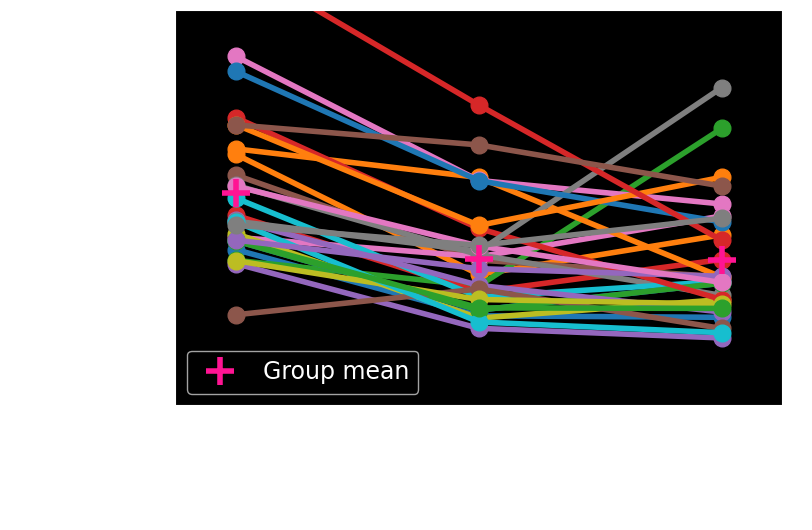

In [47]:
## individual MEAN SD IKI by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 0.12])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meansds_bybf_corr.png', dpi=300, transparent = True)
plt.show()

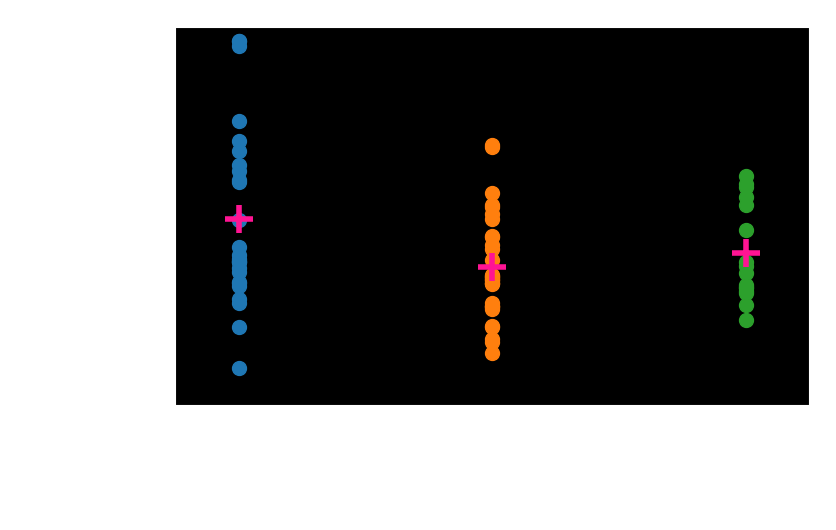

In [48]:
## bigram IKI CVs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['SD'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['SD'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['SD'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['SD']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 0.2])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

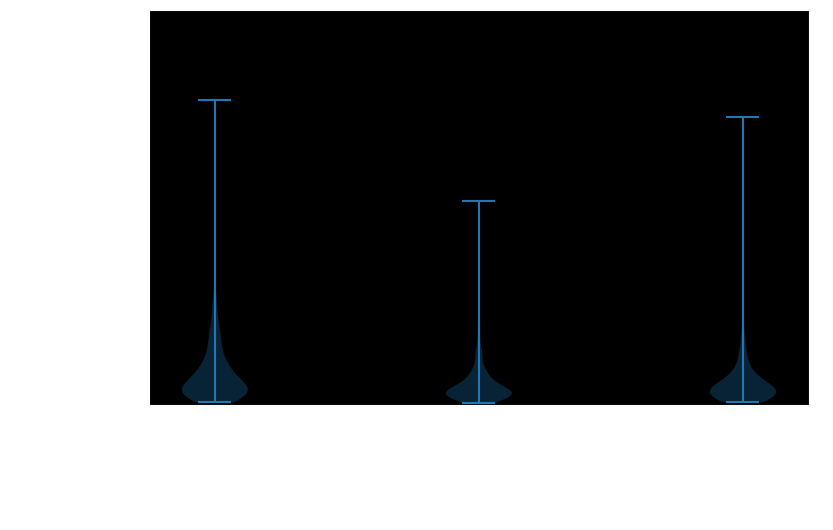

In [49]:
## all bigram IKI SDs for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D2 = list(sds[sds.bf_type == 'Low']['std'])
# x2 = [2]*len(D2)

# D4 = list(sds[sds.bf_type == 'Med']['std'])
# x4 = [4]*len(D4)

# D6 = list(sds[sds.bf_type == 'High']['std'])
# x6 = [6]*len(D6)

# means = (np.mean(sds[sds.bf_type == 'Low']['std']),
#          np.mean(sds[sds.bf_type == 'Med']['std']),
#          np.mean(sds[sds.bf_type == 'High']['std']))
# xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

D = [list(sds[sds.bf_type == 'Low']['std']),
     list(sds[sds.bf_type == 'Med']['std']),
     list(sds[sds.bf_type == 'High']['std'])]
x = (2, 4, 6)

ax.violinplot(D, x)

plt.ylim([0, 0.7])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

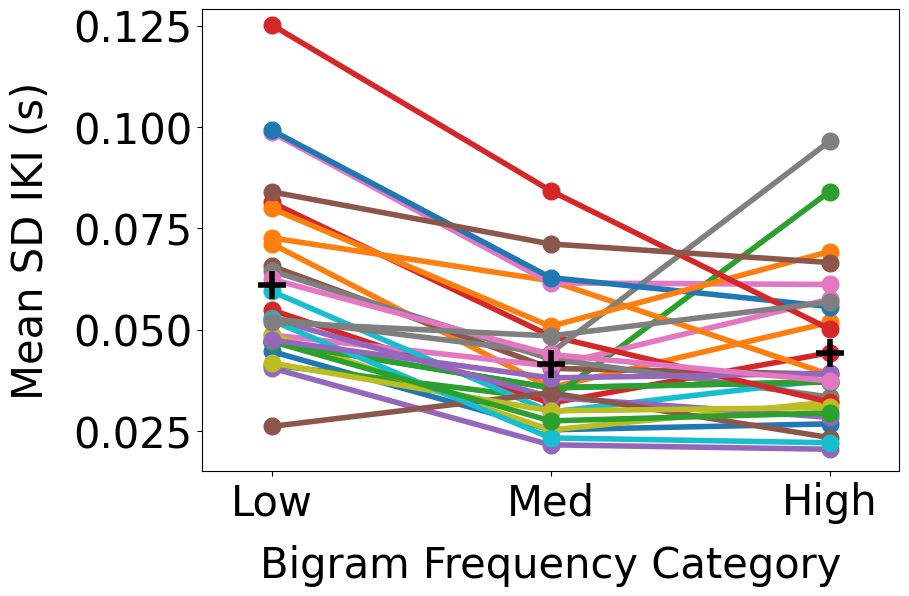

In [50]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.129])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

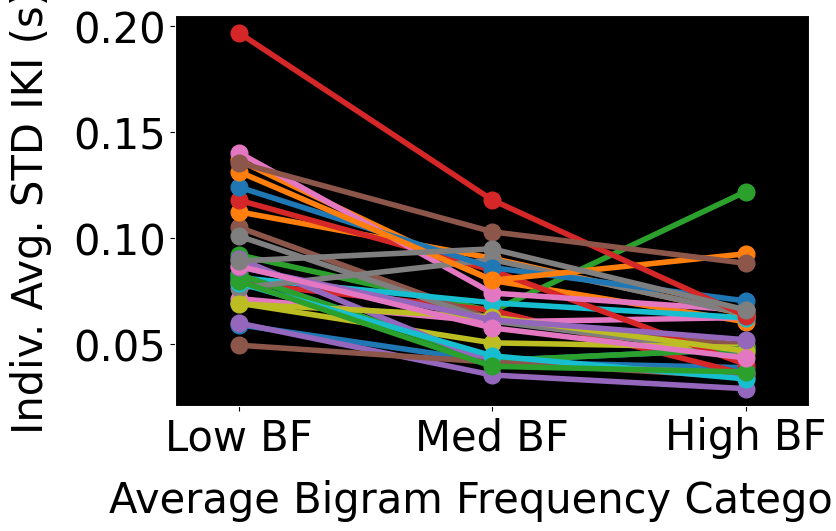

In [51]:
## individual MEAN SD IKI by AVG BF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.low_avgbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.med_avgbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.high_avgbf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

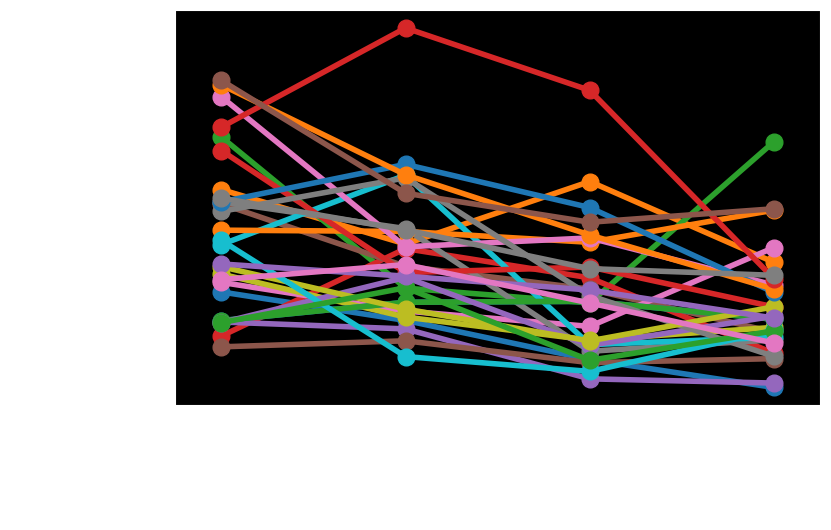

In [52]:
## individual MEAN SD IKI by WF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

## BG FREQ GRAPHS
___

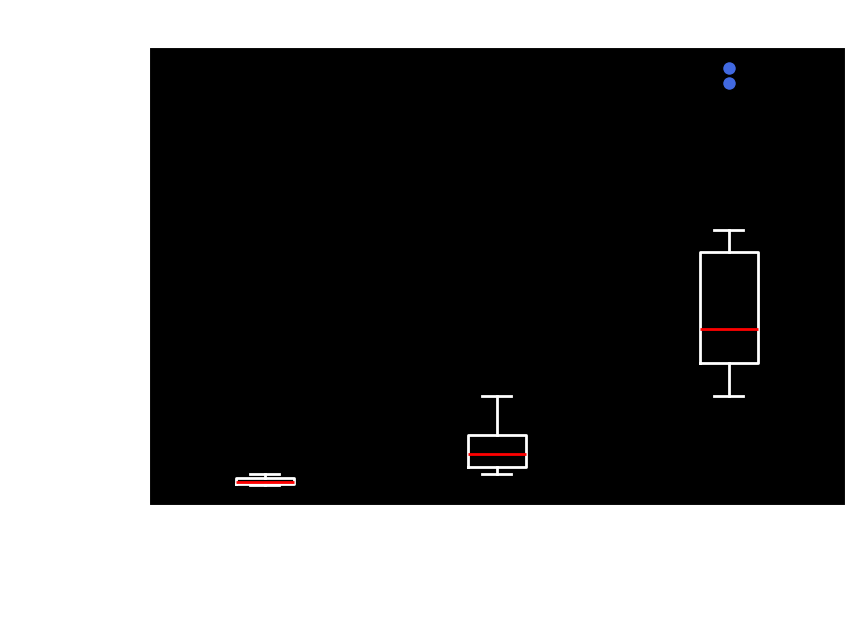

In [53]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('bf.png', dpi=300)
plt.show()

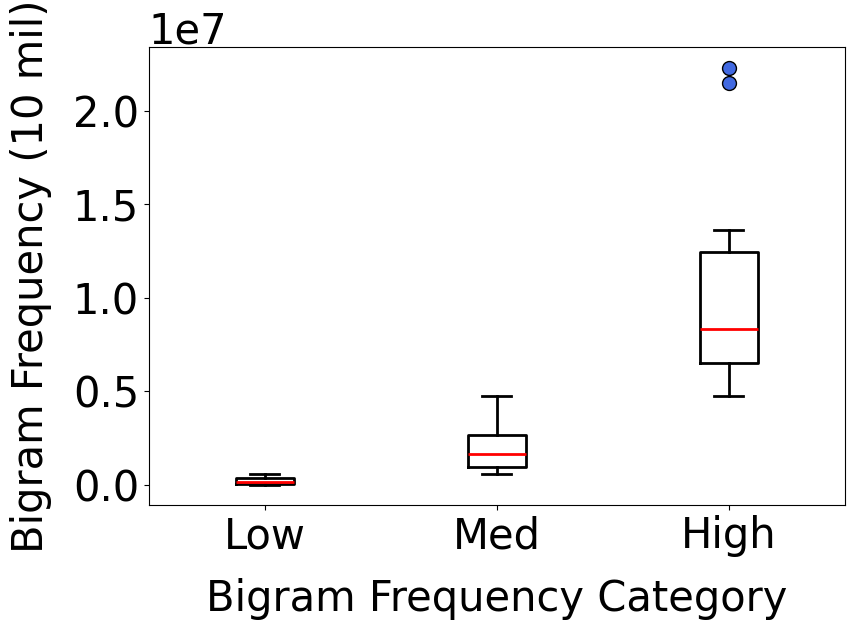

In [54]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## ERROR GRAPHS
___

In [55]:
indiv_error(incorr_bgs, 'bigram', typ.medbf)

sID  Total Error
0    s09            5
1   s175           11
2   s178            8
3   s180            8
4   s181            3
5   s182            4
6   s183           10
7   s189            1
8   s190            3
9   s198            1
10   s20           12
11  s207            4
12  s209           12
13  s210           17
14  s212            6
15  s217            3
16  s219            6
17  s224            7
18  s261            6
19  s262            3
20  s263           17
21  s267           10
22  s276            3
23  s278            9
24  s279            4
25  s282           13
26  s283           10
27  s286            9

(0      1
1     13
2      6
3      5
4      3
5      6
6     15
7      0
8      4
9      0
10     8
11     6
12     8
13    18
14     8
15     4
16     1
17     8
18     9
19     3
20     4
21     5
22     2
23    12
24     0
25     5
26     9
27     6
Name: Total Error, dtype: int64, 0      5
1     11
2      8
3      8
4      3
5      4
6     10
7      1
8      3
9      1
10    12
11     4
12    12
13    17
14     6
15     3
16     6
17     7
18     6
19     3
20    17
21    10
22     3
23     9
24     4
25    13
26    10
27     9
Name: Total Error, dtype: int64, 0      3
1      6
2     23
3      3
4     10
5      6
6     11
7      1
8      1
9      2
10     6
11     2
12     6
13     8
14     9
15     0
16     3
17     4
18     8
19     0
20    15
21     3
22    11
23     4
24     0
25    12
26    11
27     8
Name: Total Error, dtype: int64)


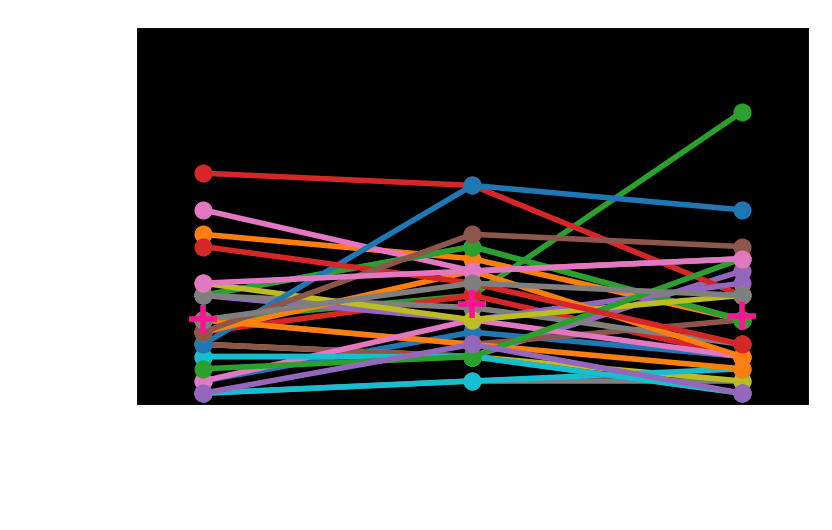

In [56]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error'])

print(D)
means = (np.mean(indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 30])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meanerr_bybf.png', dpi=300)
plt.show()

In [57]:
## Individual total trial error by AVG BF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_error(incorr_trials, 'string', typ.low_avgbf)['Total Error'], 
#      indiv_error(incorr_trials, 'string', typ.med_avgbf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.high_avgbf)['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
# plt.show()

In [58]:
## Individual total trial error by WF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]

# D = (indiv_error(incorr_trials, 'string', typ.pseudo)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.lowwf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.medwf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.highwf)['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# print([len(x) for x in D])
# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 8.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
# plt.xlabel("Word Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_avgsds.png', dpi=300)
# plt.show()

## Onset Delay

In [59]:
## calculating onset delays WF group averages by subject
od = corr_trials[['sID', 'key_resp.rt.1', 'WF Type']]
od_avgs = od.groupby(['sID', 'WF Type']).mean().reset_index()

## running anova on onset delay averages across WF groups
od_anova = pg.rm_anova(od_avgs, 'key_resp.rt.1', 'WF Type', 'sID')
print(od_anova)
pg.pairwise_tukey(od_avgs, 'key_resp.rt.1', 'WF Type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  WF Type      3     81  84.931934  6.158554e-25  0.173905  0.663979


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  highwf   lowwf  0.764197  0.818632 -0.054435  0.034983 -1.556057  0.408068   
1  highwf   medwf  0.764197  0.789089 -0.024892  0.034983 -0.711561  0.892320   
2  highwf  pseudo  0.764197  0.919359 -0.155162  0.034983 -4.435391  0.000129   
3   lowwf   medwf  0.818632  0.789089  0.029543  0.034983  0.844496  0.833057   
4   lowwf  pseudo  0.818632  0.919359 -0.100727  0.034983 -2.879335  0.024455   
5   medwf  pseudo  0.789089  0.919359 -0.130269  0.034983 -3.723830  0.001761   

      cohen  
0 -0.446781  
1 -0.222545  
2 -1.119570  
3  0.240745  
4 -0.682914  
5 -0.934763

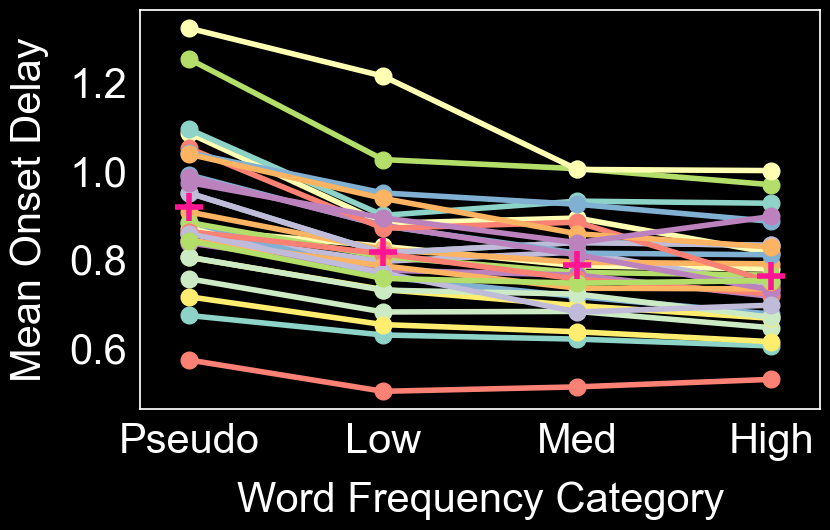

In [149]:
## plotting average onset delays by WF group
plt.style.use('dark_background')

x = [2, 4, 6, 8]
D = (od_avgs[od_avgs['WF Type'] == 'pseudo']['key_resp.rt.1'],
    od_avgs[od_avgs['WF Type'] == 'lowwf']['key_resp.rt.1'],
    od_avgs[od_avgs['WF Type'] == 'medwf']['key_resp.rt.1'],
    od_avgs[od_avgs['WF Type'] == 'highwf']['key_resp.rt.1'])

means = (np.mean(od_avgs[od_avgs['WF Type'] == 'pseudo']['key_resp.rt.1']),
        np.mean(od_avgs[od_avgs['WF Type'] == 'lowwf']['key_resp.rt.1']),
        np.mean(od_avgs[od_avgs['WF Type'] == 'medwf']['key_resp.rt.1']),
        np.mean(od_avgs[od_avgs['WF Type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig('meanod_bywf.png', dpi=300)
plt.show()

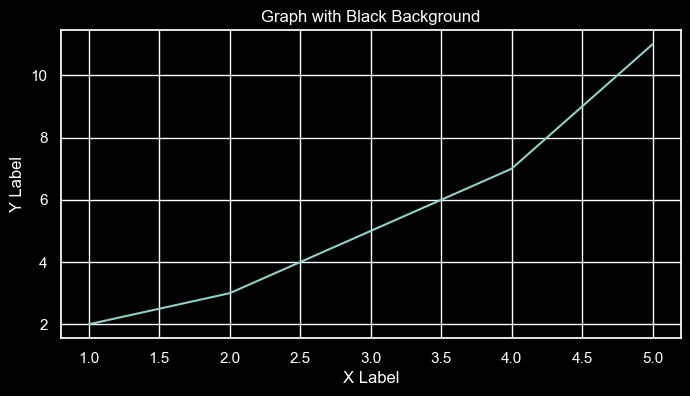

In [141]:
# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

# Create a black background
plt.style.use('dark_background')

# Plot the data
plt.plot(x, y)

# Customize labels and text to white
plt.xlabel('X Label', color='white')
plt.ylabel('Y Label', color='white')
plt.title('Graph with Black Background', color='white')

# Customize tick color to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show the plot
plt.show()

In [61]:
## defining function to calculate delta onset delay
    
def deltaod(dataframe):
    # DF = dataframe.query('string == @string')
    dataframe = dataframe.rename(columns = {'key_resp.rt.1':'onset_delay'})
    deltaods = pd.DataFrame(dataframe.groupby(['sID', 'string']).onset_delay.agg(['diff']))
    dataframe.insert(36, 'delta_od', deltaods)
    return dataframe

def indiv_meandeltaod(dataframe, sort_type):
    DF = dataframe[dataframe['WF Type'] == sort_type]
    DF = deltaod(DF)
    mean_deltaods = DF.groupby(['sID']).delta_od.agg(['mean']).reset_index()
    return mean_deltaods

In [62]:
## anova on delta onset delay comparisons across WF

deltaod_anova = pg.rm_anova(deltaod(corr_trials), 'onset_delay', 'WF Type', 'sID')
print(deltaod_anova)
pg.pairwise_tukey(od_avgs, 'key_resp.rt.1', 'WF Type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  WF Type      3     81  84.931934  6.158554e-25  0.173905  0.663979


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  highwf   lowwf  0.764197  0.818632 -0.054435  0.034983 -1.556057  0.408068   
1  highwf   medwf  0.764197  0.789089 -0.024892  0.034983 -0.711561  0.892320   
2  highwf  pseudo  0.764197  0.919359 -0.155162  0.034983 -4.435391  0.000129   
3   lowwf   medwf  0.818632  0.789089  0.029543  0.034983  0.844496  0.833057   
4   lowwf  pseudo  0.818632  0.919359 -0.100727  0.034983 -2.879335  0.024455   
5   medwf  pseudo  0.789089  0.919359 -0.130269  0.034983 -3.723830  0.001761   

      cohen  
0 -0.446781  
1 -0.222545  
2 -1.119570  
3  0.240745  
4 -0.682914  
5 -0.934763

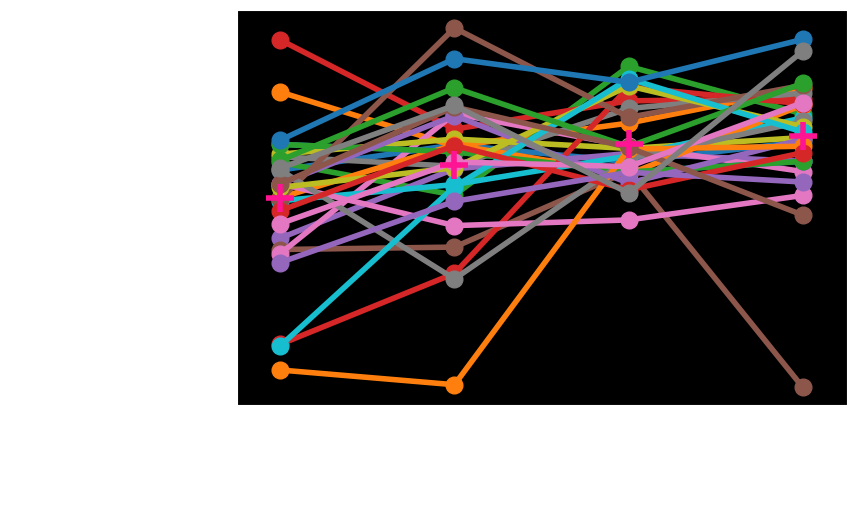

In [63]:
## plotting mean delta onset delays across WF

plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_meandeltaod(corr_trials, 'pseudo')['mean'],
    indiv_meandeltaod(corr_trials, 'lowwf')['mean'],
    indiv_meandeltaod(corr_trials, 'medwf')['mean'],
    indiv_meandeltaod(corr_trials, 'highwf')['mean'])

means = (np.mean(indiv_meandeltaod(corr_trials, 'pseudo')['mean']),
        np.mean(indiv_meandeltaod(corr_trials, 'lowwf')['mean']),
        np.mean(indiv_meandeltaod(corr_trials, 'medwf')['mean']),
        np.mean(indiv_meandeltaod(corr_trials, 'highwf')['mean']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Mean Onset Delay", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meanerr_bybf.png', dpi=300)
plt.show()

In [64]:
corr_trials

sID  Trial # string bi_1 bi_2 bi_3 bi_4 key_resp.keys.1  \
0     s210        0  druze   dr   ru   uz   ze               d   
1     s210        1  cheer   ch   he   ee   er               c   
2     s210        2  belly   be   el   ll   ly               b   
3     s210        3  puppy   pu   up   pp   py               p   
4     s210        4  champ   ch   ha   am   mp               c   
...    ...      ...    ...  ...  ...  ...  ...             ...   
6231  s283      234  vodka   vo   od   dk   ka               v   
6232  s283      236  cheer   ch   he   ee   er               c   
6233  s283      237  therm   th   he   er   rm               t   
6234  s283      238  faqir   fa   aq   qi   ir               f   
6235  s283      239  tithe   ti   it   th   he               t   

     key_resp.keys.2 key_resp.keys.3  ... key_resp.rt.10 resp_string WF Type  \
0                  r               u  ...            0.0       druze   lowwf   
1                  h               e  ...            0.0       cheer   medwf   
2                  e               l  ...            0.0       belly   medwf   
3                  u               p  ...            0.0       puppy   medwf   
4                  h               a  ...            0.0       champ   medwf   
...              ...             ...  ...            ...         ...     ...   
6231               o               d  ...            NaN       vodka   medwf   
6232               h               e  ...            NaN       cheer   medwf   
6233               h               e  ...            NaN       therm   lowwf   
6234               a               q  ...            NaN       faqir   lowwf   
6235               i               t  ...            NaN       tithe   lowwf   

     BF Type     iki_1     iki_2     iki_3     iki_4  iki_5  iki_6  
0        NaN  0.183920  0.264119  0.343897  0.256079    0.0    0.0  
1        NaN  0.143879  0.184087  0.175978  0.103960    0.0    0.0  
2        NaN  0.263867  0.184046  0.151993  0.192014    0.0    0.0  
3        NaN  0.199958  0.240110  0.151904  0.432082    0.0    0.0  
4        NaN  0.104000  0.144114  0.095972  0.223897    0.0    0.0  
...      ...       ...       ...       ...       ...    ...    ...  
6231     NaN  0.208113  0.175922  0.287961  0.160107    0.0    0.0  
6232     NaN  0.135930  0.104032  0.136009  0.152097    0.0    0.0  
6233     NaN  0.095960  0.128208  0.160095  0.087842    0.0    0.0  
6234     NaN  0.375904  0.215971  0.192123  0.111855    0.0    0.0  
6235     NaN  0.111949  0.080166  0.151992  0.087917    0.0    0.0  

[6236 rows x 36 columns]

In [65]:
# data = corr_trials[corr_trials['WF Type'] == 'pseudo'].reset_index()['key_resp.rt.1']

for ID in ID_list:
    DF = corr_trials.loc[(corr_trials['string'] == 'pykka') & (corr_trials['sID'] == ID)]
        
        
DF

sID  Trial # string bi_1 bi_2 bi_3 bi_4 key_resp.keys.1  \
5140  s286        6  pykka   py   yk   kk   ka               p   
5149  s286       16  pykka   py   yk   kk   ka               p   
5185  s286       59  pykka   py   yk   kk   ka               p   
5224  s286      102  pykka   py   yk   kk   ka               p   
5246  s286      124  pykka   py   yk   kk   ka               p   
5261  s286      142  pykka   py   yk   kk   ka               p   
5300  s286      183  pykka   py   yk   kk   ka               p   
5320  s286      204  pykka   py   yk   kk   ka               p   
5330  s286      214  pykka   py   yk   kk   ka               p   

     key_resp.keys.2 key_resp.keys.3  ... key_resp.rt.10 resp_string WF Type  \
5140               y               k  ...            NaN       pykka  pseudo   
5149               y               k  ...            NaN       pykka  pseudo   
5185               y               k  ...            NaN       pykka  pseudo   
5224               y               k  ...            NaN       pykka  pseudo   
5246               y               k  ...            NaN       pykka  pseudo   
5261               y               k  ...            NaN       pykka  pseudo   
5300               y               k  ...            NaN       pykka  pseudo   
5320               y               k  ...            NaN       pykka  pseudo   
5330               y               k  ...            NaN       pykka  pseudo   

     BF Type     iki_1     iki_2     iki_3     iki_4  iki_5  iki_6  
5140     NaN  0.343985  0.383998  0.151997  0.120007    0.0    0.0  
5149     NaN  0.335975  0.352175  0.135934  0.143919    0.0    0.0  
5185     NaN  0.351976  0.360107  0.136090  0.127877    0.0    0.0  
5224     NaN  0.400001  0.328012  0.160069  0.151909    0.0    0.0  
5246     NaN  0.344023  0.336077  0.151919  0.112141    0.0    0.0  
5261     NaN  0.384053  0.335942  0.183980  0.119977    0.0    0.0  
5300     NaN  0.415958  0.336061  0.167974  0.119971    0.0    0.0  
5320     NaN  0.399984  0.360205  0.175774  0.119996    0.0    0.0  
5330     NaN  0.399947  0.335951  0.167993  0.152126    0.0    0.0  

[9 rows x 36 columns]

In [66]:
DF['key_resp.rt.1']

5140    1.179997
5149    0.995731
5185    1.022361
5224    0.816975
5246    0.665561
5261    0.720896
5300    0.787385
5320    0.630580
5330    0.966285
Name: key_resp.rt.1, dtype: float64

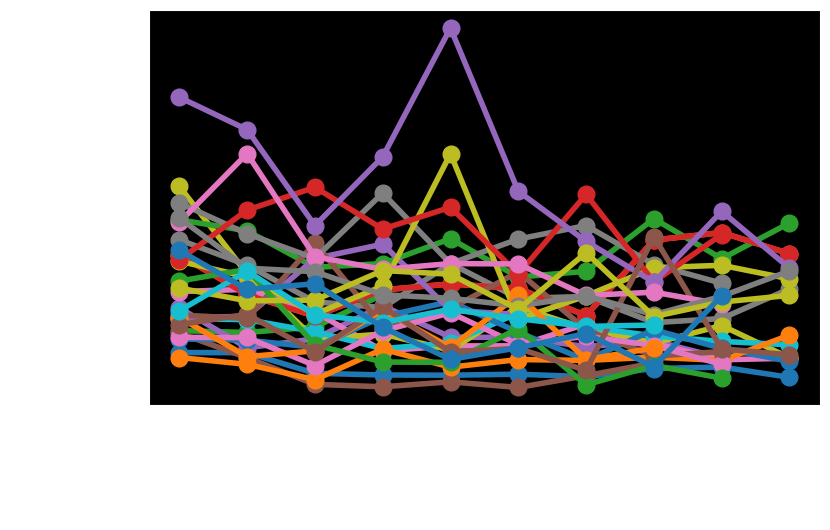

In [67]:
## plot ods over trials across individuals



plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]
# D = (indiv_meandeltaod(corr_trials, 'pseudo')['mean'],
#     indiv_meandeltaod(corr_trials, 'lowwf')['mean'],
#     indiv_meandeltaod(corr_trials, 'medwf')['mean'],
#     indiv_meandeltaod(corr_trials, 'highwf')['mean'])

data = corr_trials[corr_trials['WF Type'] == 'pseudo'].reset_index()['key_resp.rt.1']

# means = (np.mean(indiv_meandeltaod(corr_trials, 'pseudo')['mean']),
#         np.mean(indiv_meandeltaod(corr_trials, 'lowwf')['mean']),
#         np.mean(indiv_meandeltaod(corr_trials, 'medwf')['mean']),
#         np.mean(indiv_meandeltaod(corr_trials, 'highwf')['mean']))

fig, ax = plt.subplots(figsize=(9, 6))

for ID in ID_list:
    DF = corr_trials.loc[(corr_trials['string'] == 'pykka') & (corr_trials['sID'] == ID)].reset_index()
    ax.plot(DF.index.to_list(), DF['key_resp.rt.1'].to_list(), '.-', linewidth = 4, ms = 24)
    
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([-1, 30])
# plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Mean Onset Delay", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meanerr_bybf.png', dpi=300)
plt.show()

## Bigram-Word Interaction
___

In [68]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

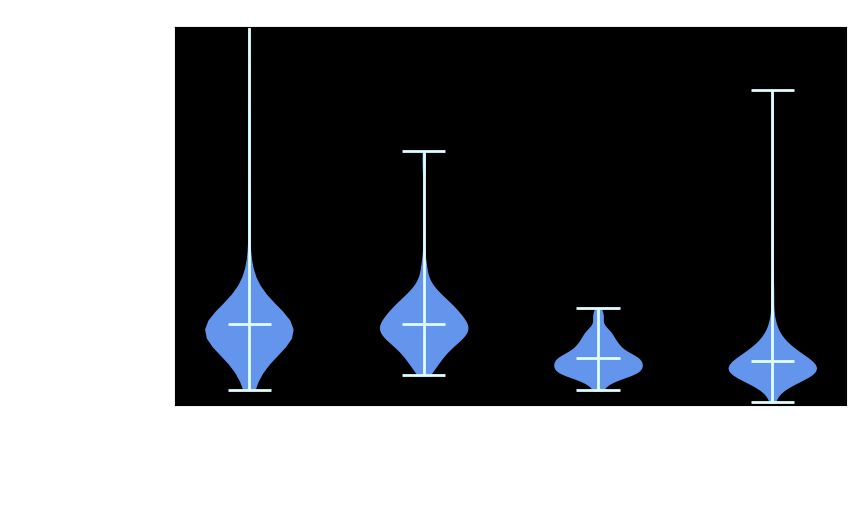

In [69]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'edthe' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("cornflowerblue")
    pc.set_edgecolor("cornflowerblue")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('he', 'eo', 'on', 'nd'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('heond_dist.png', dpi=300, transparent = True)

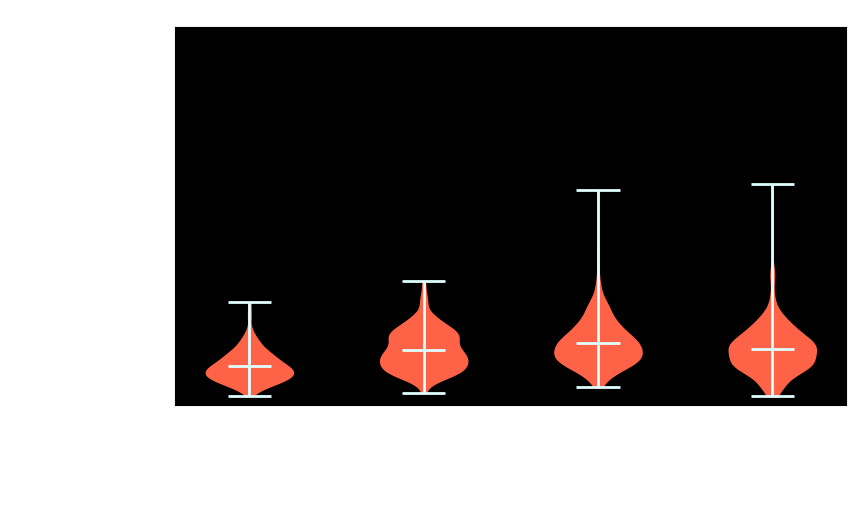

In [70]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'think' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("tomato")
    pc.set_edgecolor("tomato")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'hi', 'in', 'nk'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('think_dist.png', dpi=300, transparent = True)

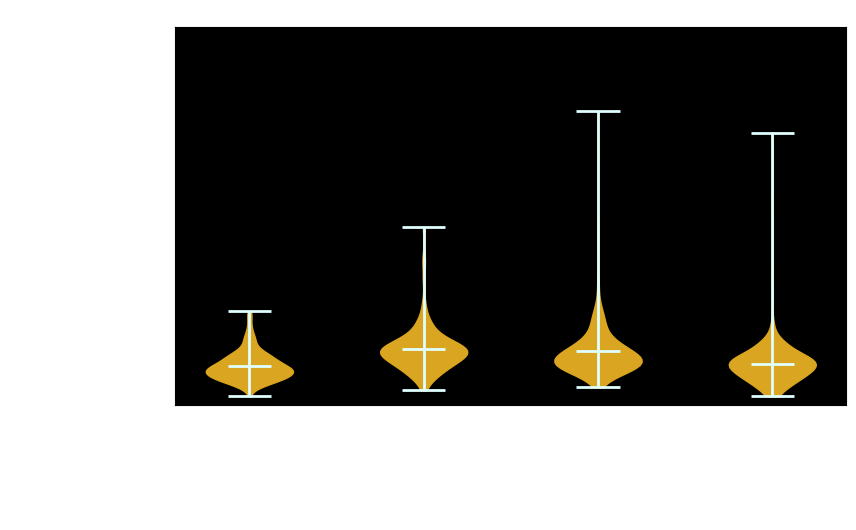

In [71]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'theme' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("goldenrod")
    pc.set_edgecolor("goldenrod")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'he', 'em', 'me'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('theme_dist.png', dpi=300, transparent = True)

<Axes: >

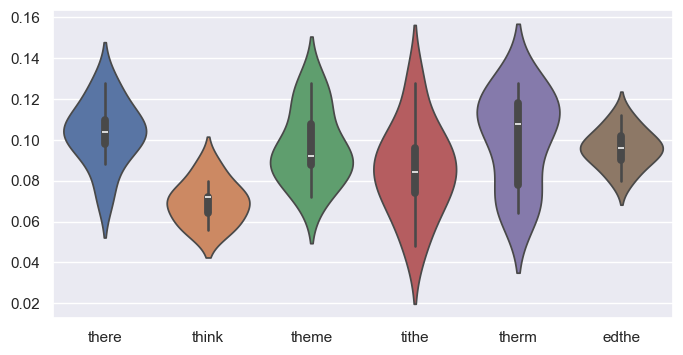

In [72]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 'th' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's180') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with_onesub)

<Axes: >

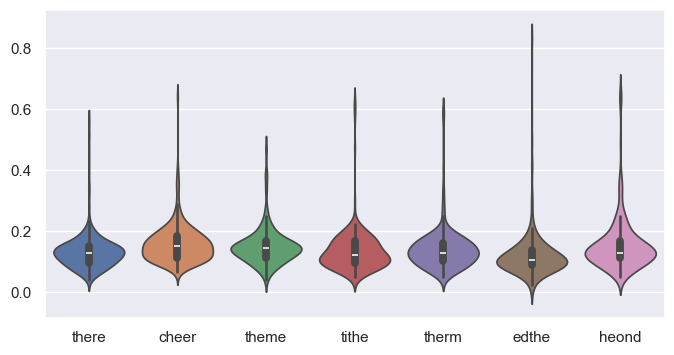

In [73]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 'he' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

<Axes: >

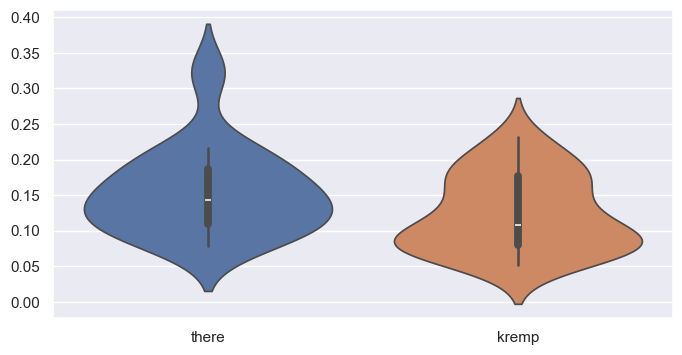

In [74]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

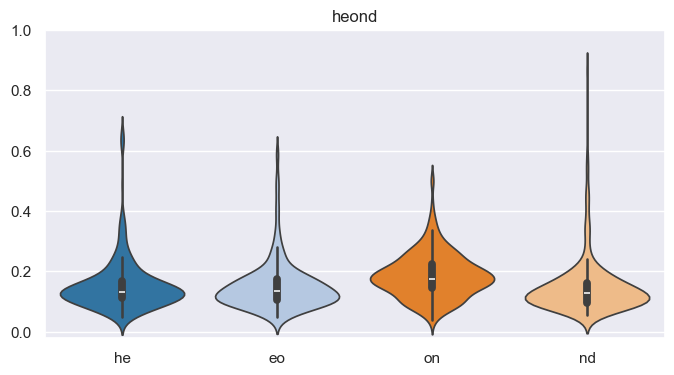

In [75]:
string = 'heond' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
fig, ax = plt.subplots()
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='tab20', ax=ax).set(title = string)
ax.set_ylim(-0.02,1)
plt.show()

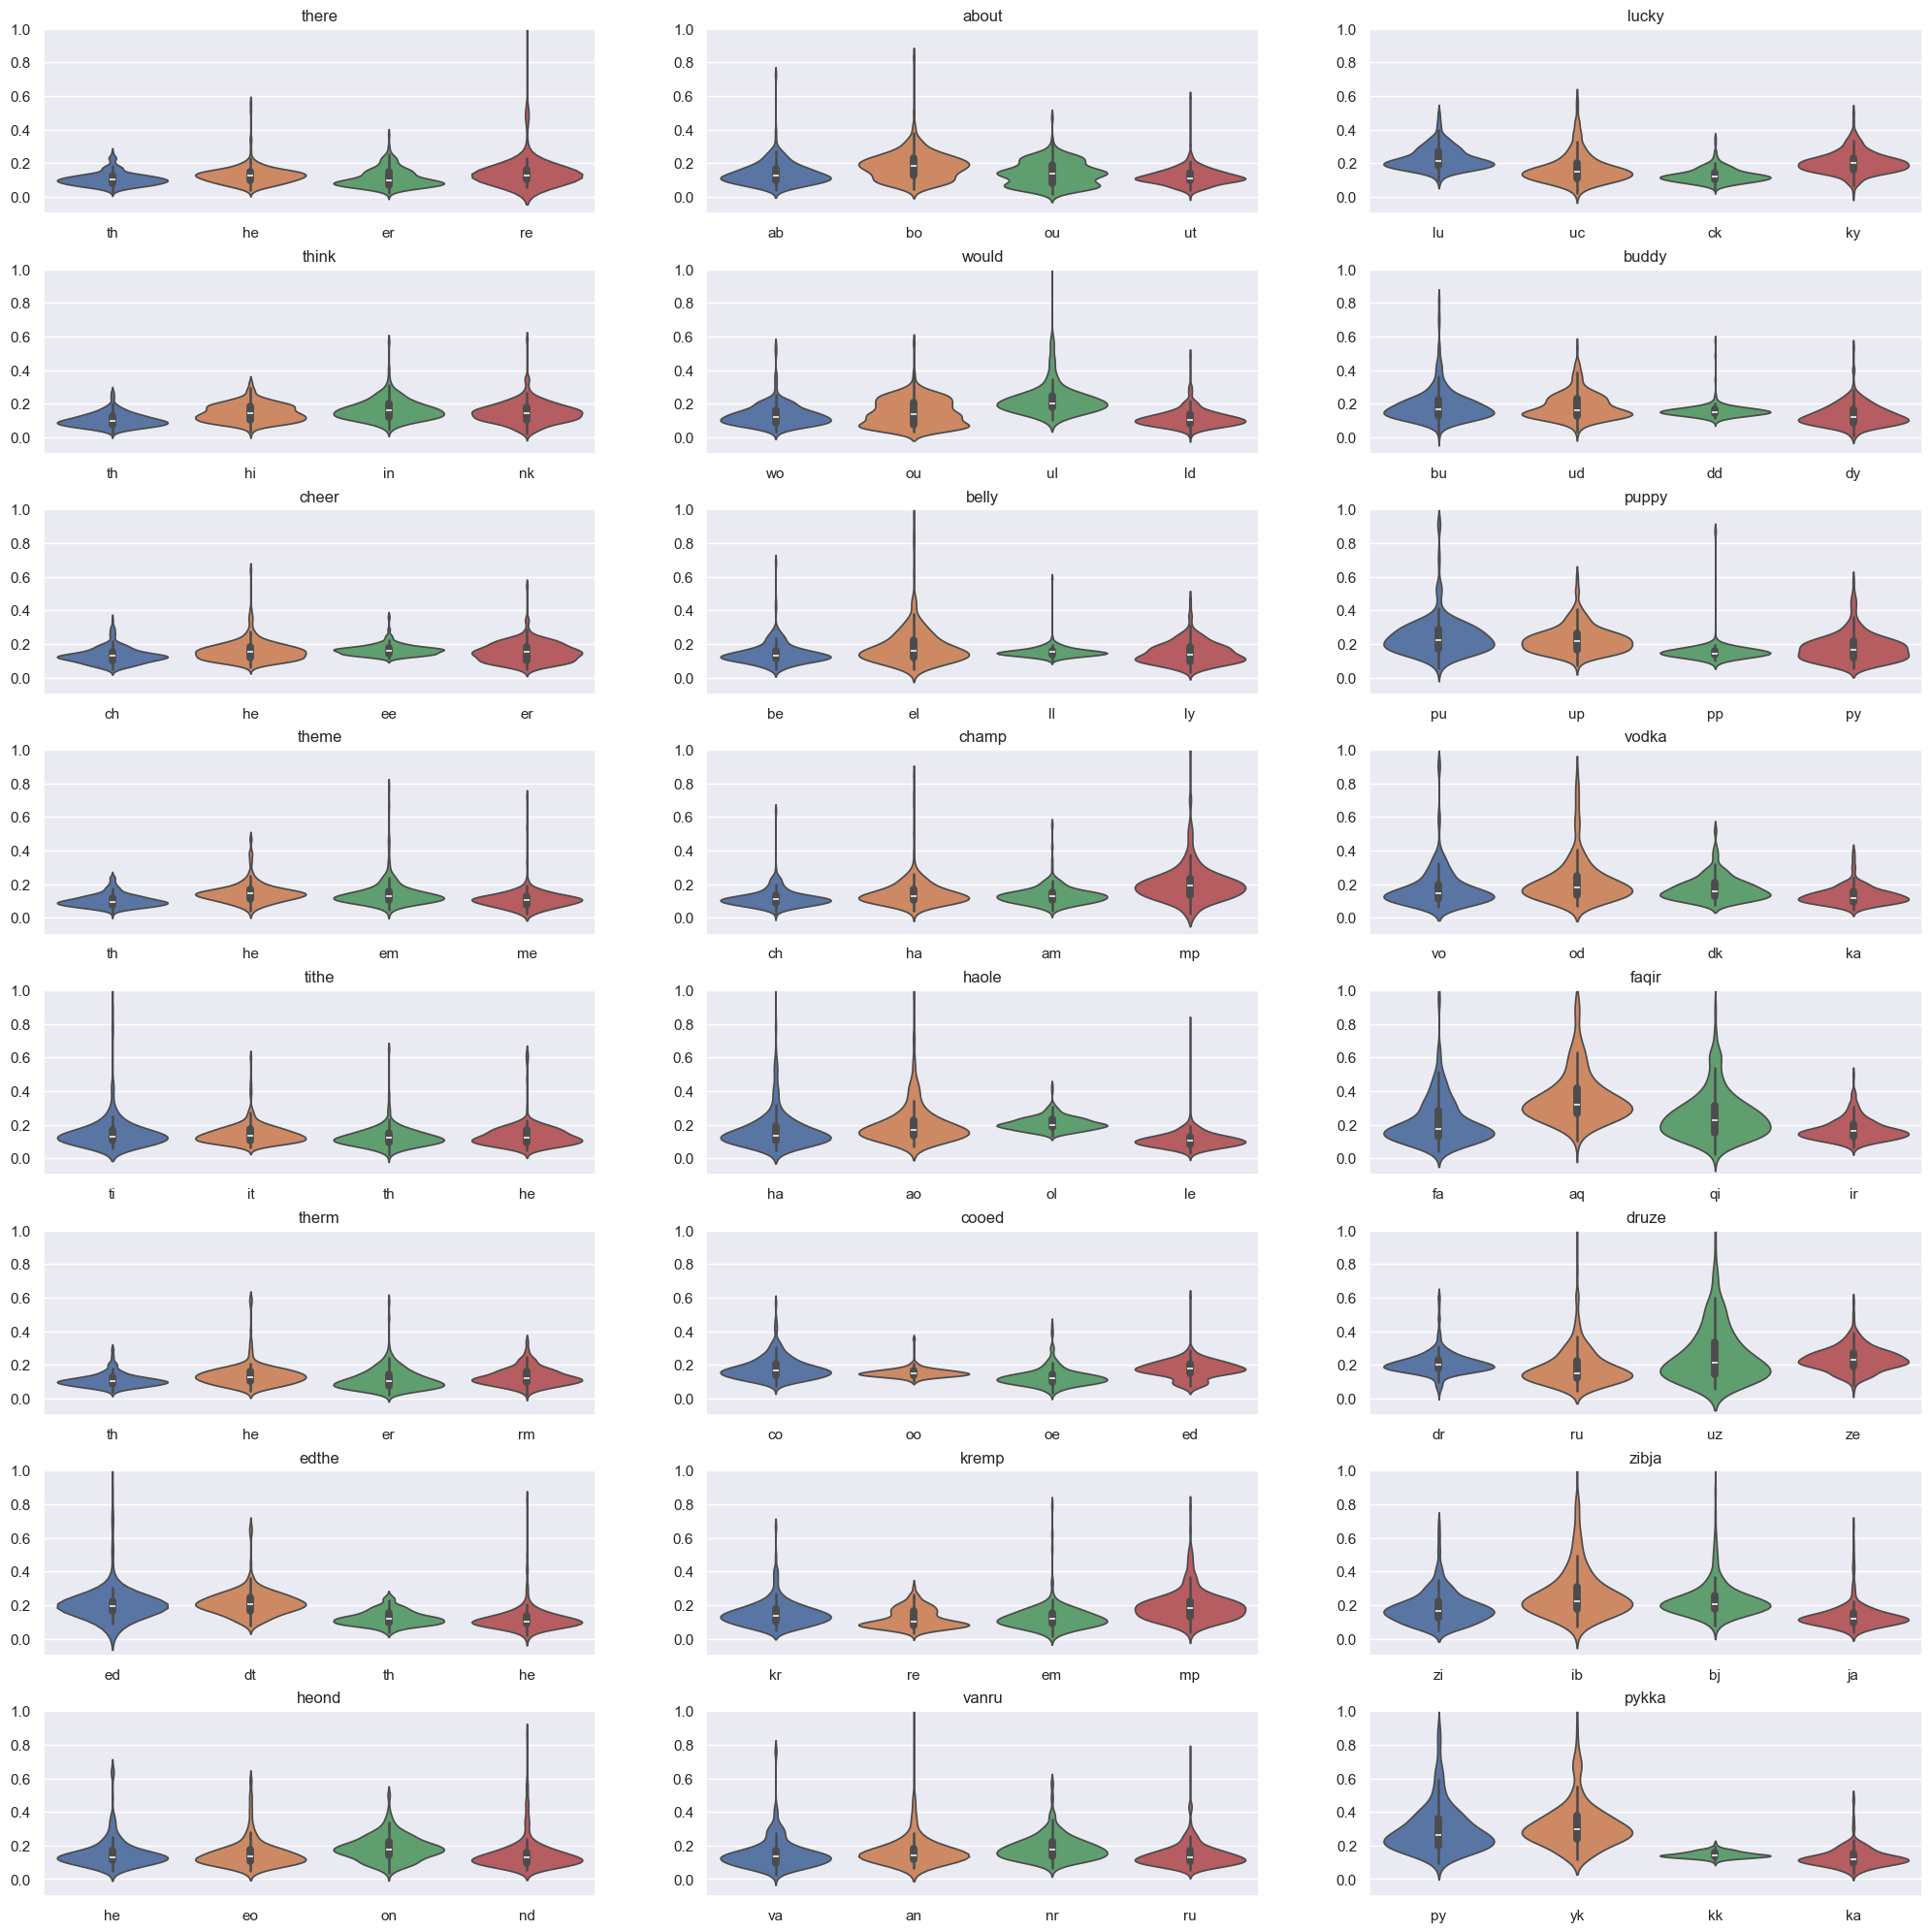

In [76]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

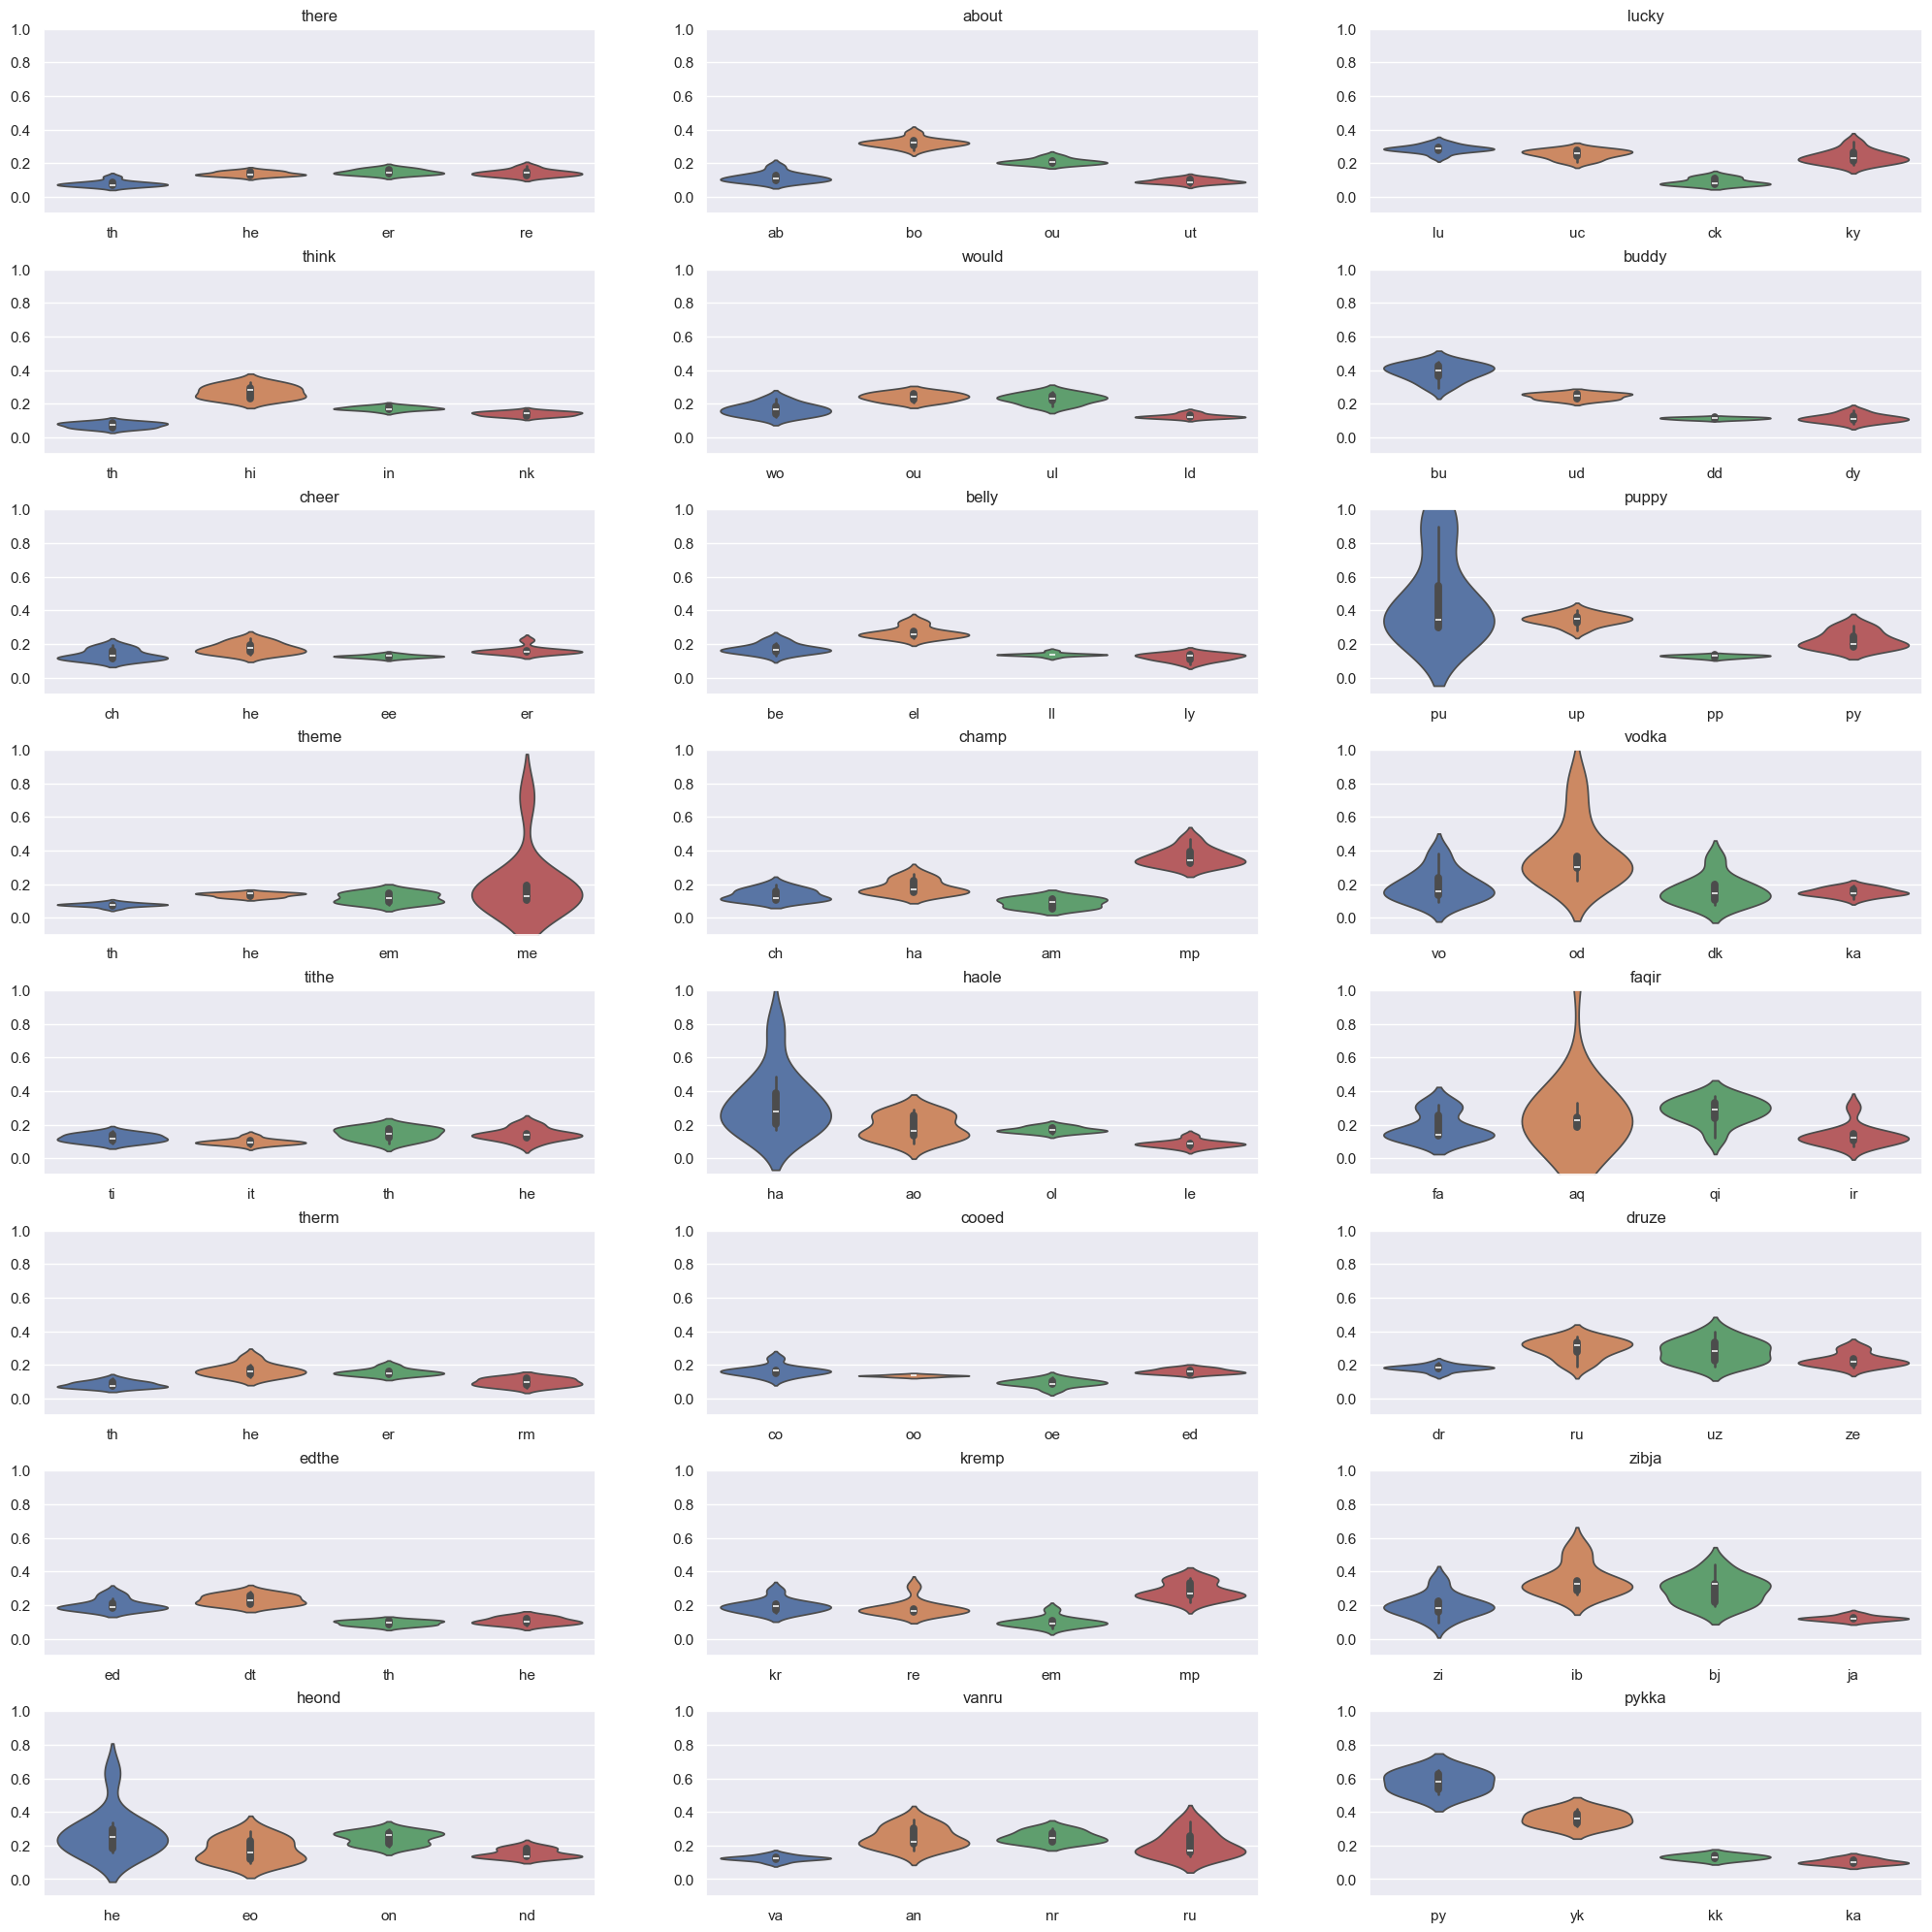

In [77]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

## Delta IKI

In [78]:
# def indiv_cvs_bybg(string, bigram):
#     DF = tight_bgs.query('string == @string and bigram == @bigram')
#     cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
#     return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

# def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     elif str_or_bg == 'bigram':
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
#     # means.columns = ['Avg IKI']
#     return means

all_bigrams

# def deltaiki(dataframe,):

def deltaiki_bybg(dataframe, string, bigram):
    DF = dataframe.query('string == @string and bigram == @bigram')
    deltaikis = pd.DataFrame(DF.groupby('sID').IKI.agg(['diff'])).abs()
    DF.insert(7, 'delta_iki', deltaikis)
    # deltaikis.insert(0, 'sID', DF['sID'])
    # for ID in ID_list:
    #     deltaikis
    # return DF.get_group('s210')
    # return DF[DF.sID == 's209']
    return DF
    # return deltaikis
    
def indiv_deltaiki_bybg(sID, dataframe, string, bigram):
    DF = deltaiki_bybg(dataframe, string, bigram)
    DF = DF[DF.sID == sID].reset_index().drop(0)
    return DF

indiv_deltaiki_bybg('s209', all_bigrams, 'there', 'th')

index   sID  Bigram #  trial  bigram_loc bigram corr_bigram       IKI  \
1   2047  s209       128     31           0     th          th  0.056027   
2   2083  s209       164     40           0     th          th  0.080027   
3   2325  s209       406    100           0     th          th  0.095944   
4   2353  s209       434    107           0     th          th  0.112028   
5   2414  s209       495    122           0     th          th  0.103933   
6   2442  s209       523    129           0     th          th  0.103937   
7   2487  s209       568    140           0     th          th  0.079892   
8   2655  s209       736    181           0     th          th  0.096162   
9   2754  s209       835    206           0     th          th  0.087939   

   delta_iki string resp_string  rep #     bg_freq bf_type meanbf_type wf_type  
1   0.023979  there       there      1  22288309.0    high        high    high  
2   0.024000  there       there      2  22288309.0    high        high    high  
3   0.015918  there       there      3  22288309.0    high        high    high  
4   0.016084  there       there      4  22288309.0    high        high    high  
5   0.008095  there       there      5  22288309.0    high        high    high  
6   0.000004  there       there      6  22288309.0    high        high    high  
7   0.024046  there       there      7  22288309.0    high        high    high  
8   0.016270  there       there      8  22288309.0    high        high    high  
9   0.008222  there       there      9  22288309.0    high        high    high

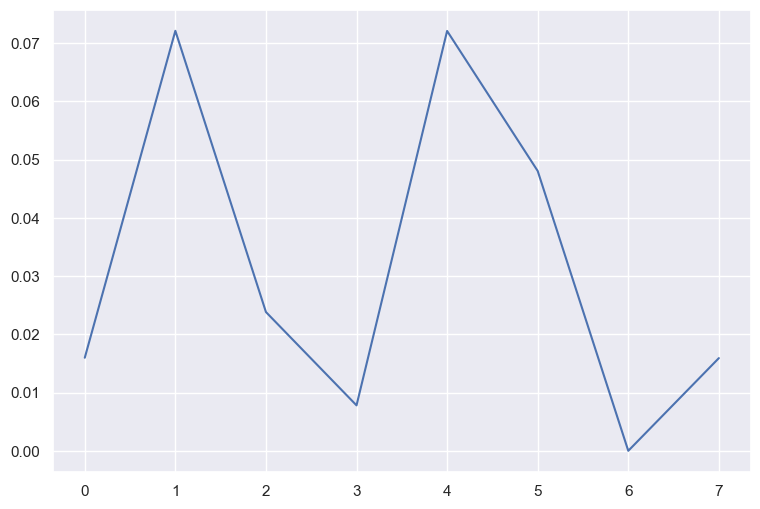

In [79]:
x = list(range(0, 8))
y = list(indiv_deltaiki_bybg('s209', corr_trials_bybg, 'zibja', 'bj')['delta_iki'])

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, y)

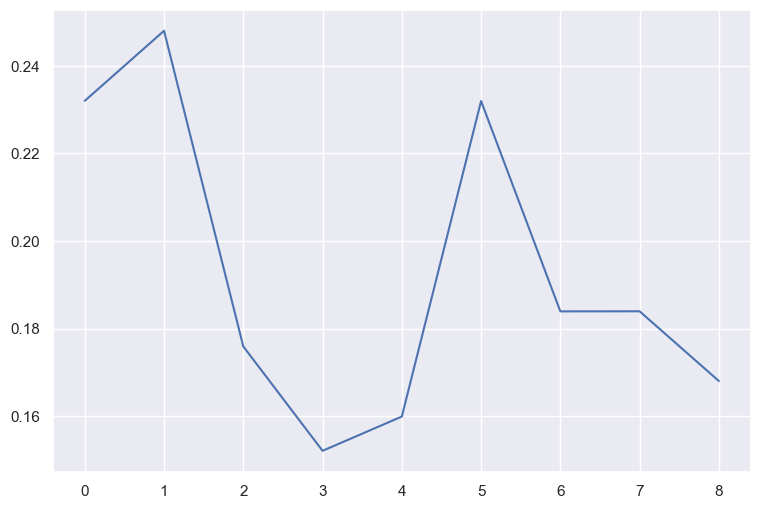

In [80]:
def indiv_ikis(sID, dataframe, string, bigram):
    DF = dataframe.query('sID == @sID & string == @string & bigram == @bigram')
    return DF

indiv_ikis('s209', corr_bgs, 'there', 'th')

x = list(range(0, 9))
y = list(indiv_ikis('s209', corr_trials_bybg, 'zibja', 'bj')['IKI'])

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, y)

## KIND OF USEFUL GRAPHS
____

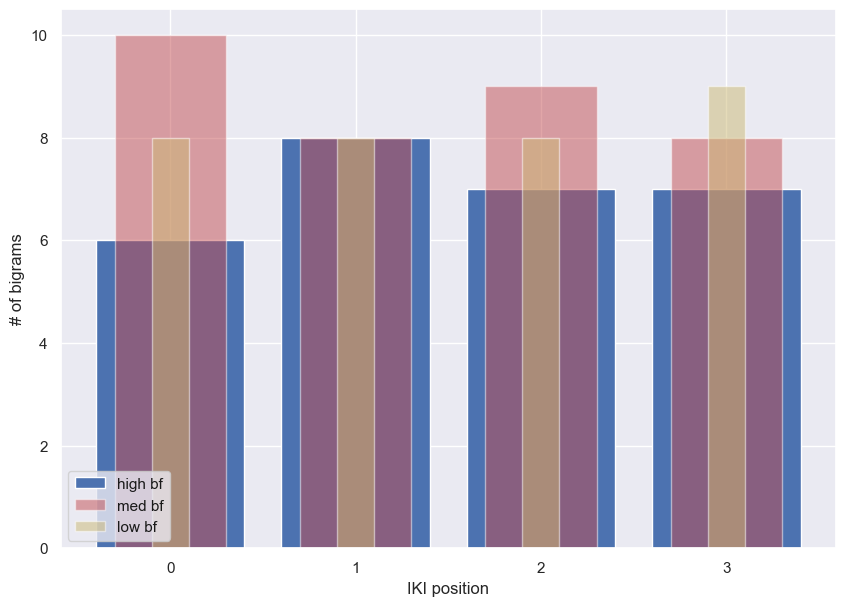

In [81]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

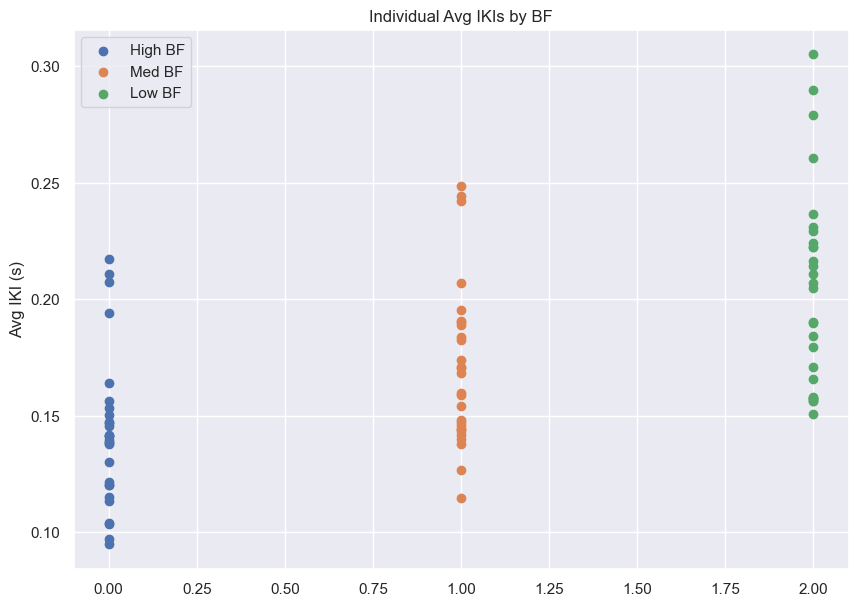

In [82]:
## Raster plot of indiv. MEAN IKI by BF

plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter([0] * len(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'], 
                              label='High BF')
medbf_scatter = plt.scatter([1] * len(indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI'], 
                              label='Med BF')
Lowbf_scatter = plt.scatter([2] * len(indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI'], 
                              label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

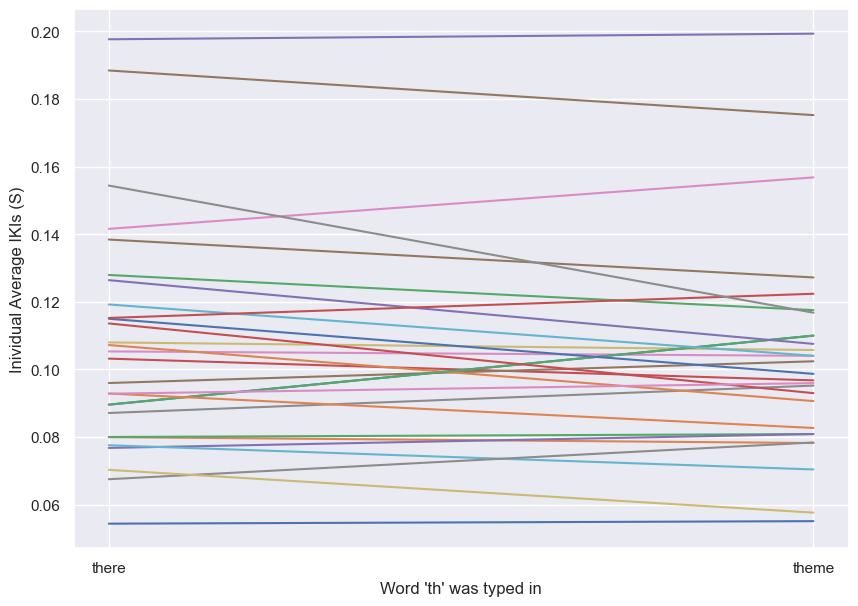

In [83]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

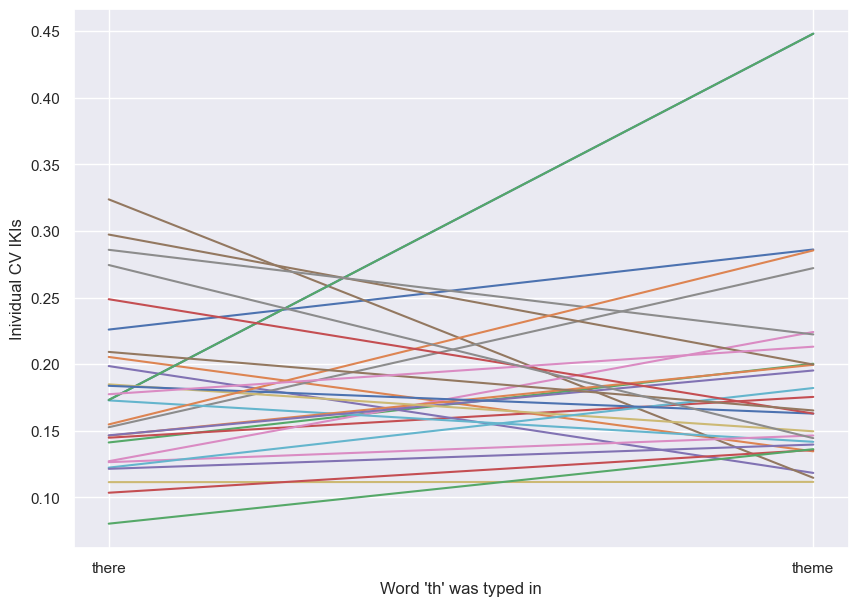

In [84]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

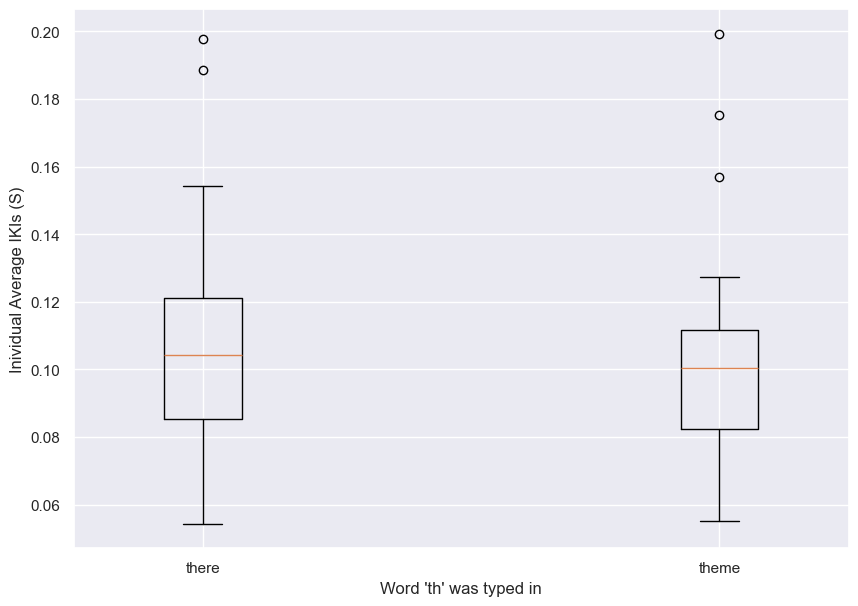

In [85]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

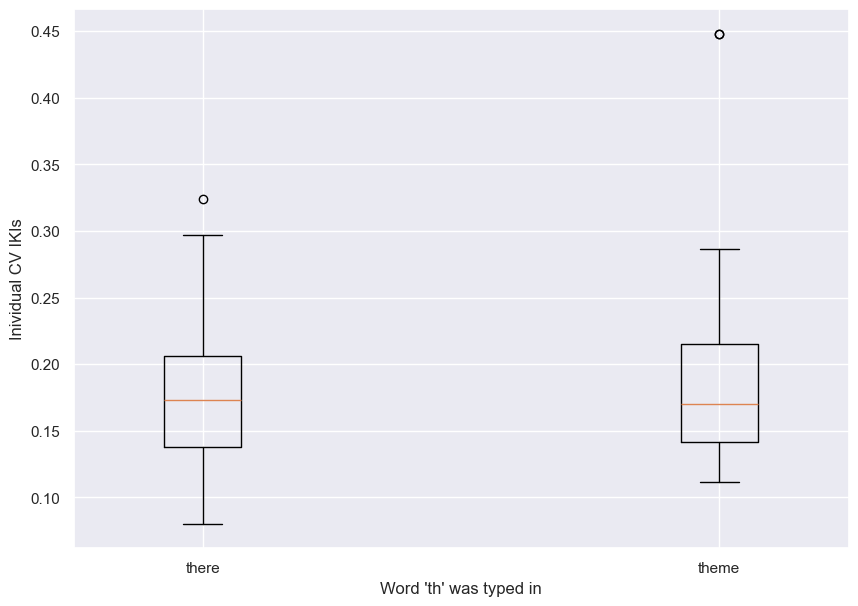

In [86]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

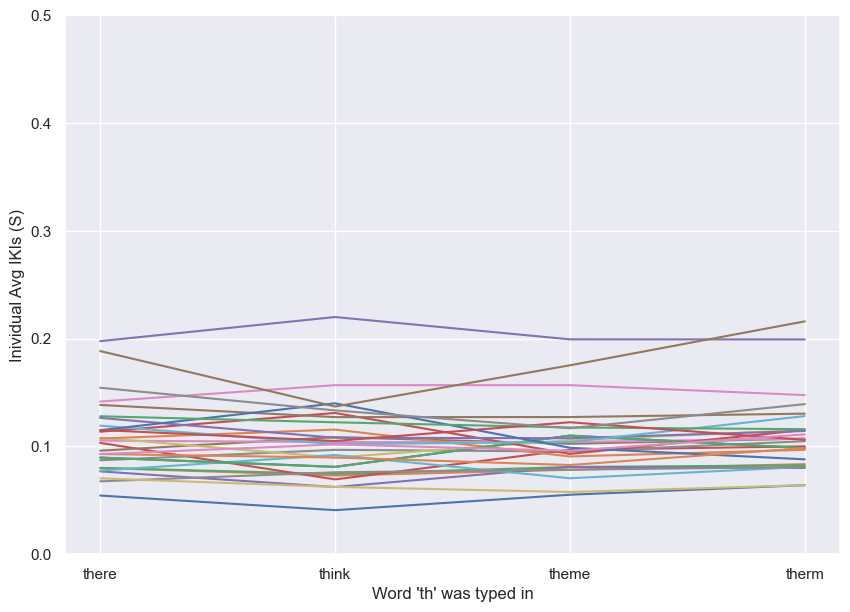

In [87]:
x = [2, 4, 6, 8]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('think', 'th')['mean'], 
     indiv_means_bybg('theme', 'th')['mean'], indiv_means_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

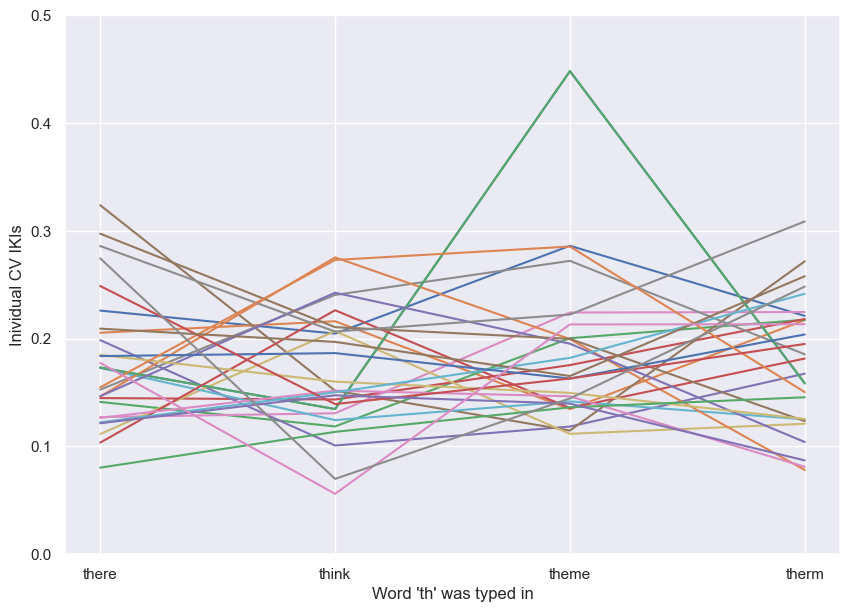

In [88]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [89]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [90]:
# ## plotting digraph latency variations by WF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig('ian_iki.png')

# plt.show()

In [91]:
# ## plotting digraph latency variations by WF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by WF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [92]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.high_avgbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.med_avgbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.low_avgbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [93]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.high_avgbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.med_avgbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.low_avgbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [94]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [95]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.high_avgbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.med_avgbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.low_avgbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# WIP
___

In [96]:
## running wilcoxon rank-sum test between IKI and CV IKI
# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

In [97]:
# def delta_iki(bigram, string):
#     all_deltas = []
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         deltas = [sub]
#         for trial in range(0, len(sub_df) - 1):
#             deltas.append(sub_df.loc[trial + 1, 'IKI'] - sub_df.loc[trial, 'IKI']) ## depends on column position
#         all_deltas.append(deltas)
#     all_deltas = pd.DataFrame(all_deltas)
#     all_deltas = all_deltas.transpose()
#     return all_deltas

In [98]:
# def iki_change_bysub(bigram, string):
#     all_subs = pd.DataFrame()
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         ikis = sub_df['IKI'].tolist()
#         while len(ikis) != 10:
#             ikis.append(np.nan)
#         all_subs[sub] = ikis
#     return all_subs
        
# iki_change_bysub('pu', 'puppy')

In [99]:
##plotting IKI accross repetitions for each individual

# df = iki_change_bysub('pu', 'puppy')

# df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Repetition #")
# plt.ylabel("IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend().remove()

# plt.show()

In [100]:
## plotting average IKI for a particular bigram in a particular word across repetitions (for correct trials only)

# plt.figure(figsize=(10, 7))
# for bg in typ.lowbf:
#     by_bg = corr_trials_bybg[corr_trials_bybg.bigram == bg]
#     rep_ikis = []
#     for n in range(0, 9):
#         all_reps = by_bg[by_bg['rep #'] == n]
#         avg_iki_byrep = all_reps['IKI'].mean()
#         rep_ikis.append(avg_iki_byrep)

#         plt.plot(rep_ikis)

#         # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
#         plt.xlabel("Repetition #")
#         plt.ylabel("Avg IKI (s)")
#         # plt.ylim([0, 0.8])
#         plt.title("")
#         # plt.legend().remove()

# plt.show()

In [101]:
# yk_df = delta_iki('dk', 'vodka')[1:]

# yk_df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Inter-repetition position")
# plt.ylabel("Delta IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend(loc="best")

# plt.show()

In [102]:
# def indiv_means_bgonly(bigram):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_bgonly(bigram):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

In [103]:
# all_indiv_means = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

# all_indiv_cvs = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

In [104]:
## plot of individual avg iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_means[all_indiv_means.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['Avg IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 0.4])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [105]:
## plot of individual cv iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['CV IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 1])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [106]:
# th_means = pd.concat([indiv_means_bybg('there', 'th'), indiv_means_bybg('think', 'th'), indiv_means_bybg('theme', 'th'), indiv_means_bybg('therm', 'th')]
#                      , ignore_index=True)
# print(th_means)

# # print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [107]:
# th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
#                      , ignore_index=True)

# print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [108]:
# th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

In [109]:
# th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [110]:
# th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [111]:
# th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

# MRS Correlation
___

In [112]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant_filtered.csv')

GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data

In [113]:
## filtering corr_bgs to only have subjects with GABA data
GABA_corr_bgs = corr_bgs[corr_bgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)

In [114]:
## calculating mean and sd iki across all bigram categories for GABA subjects only  
GABA_means = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'all_mean_iki'})
GABA_sds = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['std'])).reset_index().rename(columns = {'std':'all_sd_iki'})

In [115]:
## making filtered dataframes for the voxels of interest
# GABA_Rthal = GABA_df[(GABA_df.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)
# GABA_Lthal = GABA_df[(GABA_df.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)
# GABA_RLthal = pd.concat([GABA_Rthal, GABA_Lthal])

# GABA_RM1 = GABA_df[(GABA_df.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)
# GABA_LM1 = GABA_df[(GABA_df.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)
# GABA_RLM1 = pd.concat([GABA_RM1, GABA_LM1])

# # l_voxs = pd.concat([GABA_Lthal, GABA_LM1]).reset_index(drop=True)
# # r_voxs = pd.concat([GABA_Rthal, GABA_RM1]).reset_index(drop=True)

In [116]:
## making summary df with all relevant info
GABA_df = pd.concat([pd.DataFrame(GABA_sIDs),
                     indiv_means(GABA_corr_bgs, 'bigram', typ.lowbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.medbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.highbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.all_bigrams)['Avg IKI'],
                     GABA_means['all_mean_iki'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.lowbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.medbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.highbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.all_bigrams)['Avg SD IKI'],
                     GABA_sds['all_sd_iki'],
                     GABA_quant[(GABA_quant.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr']],
                     axis=1).reset_index(drop=True)

labels = ['sID', 
          'low_mean_iki',
          'med_mean_iki',
          'high_mean_iki',
          'all_avg_mean_iki',
          'all_mean_iki',
          'low_sd_iki', 
          'med_sd_iki', 
          'high_sd_iki', 
          'all_avg_sd_iki',
          'all_sd_iki',
          'R_thal_GABA', 
          'L_thal_GABA', 
          'R_M1_GABA', 
          'L_M1_GABA']
GABA_df.columns = labels
GABA_df

# print(np.std(GABA_df.low_sd_iki))
# print(np.std(GABA_df.med_sd_iki))
# print(np.std(GABA_df.high_sd_iki))

sID  low_mean_iki  med_mean_iki  high_mean_iki  all_avg_mean_iki  \
0   s09      0.171395      0.122012       0.100771          0.129063   
1   s20      0.154600      0.140580       0.114512          0.135337   
2  s209      0.154600      0.140580       0.114512          0.135337   
3  s261      0.156836      0.139021       0.120911          0.137923   
4  s262      0.157754      0.138180       0.097326          0.129549   
5  s263      0.219075      0.186762       0.146160          0.182596   
6  s276      0.214389      0.163653       0.138764          0.170538   
7  s278      0.225491      0.179550       0.114645          0.168783   
8  s279      0.260474      0.246385       0.217313          0.240455   
9  s282      0.287024      0.244854       0.210510          0.245906   

   all_mean_iki  low_sd_iki  med_sd_iki  high_sd_iki  all_avg_sd_iki  \
0      0.129063    0.044573    0.025628     0.026763        0.032624   
1      0.135337    0.046964    0.048606     0.036541        0.045377   
2      0.135337    0.046964    0.048606     0.036541        0.045377   
3      0.137923    0.045107    0.030890     0.030722        0.035917   
4      0.129549    0.055679    0.027952     0.021944        0.036511   
5      0.182596    0.096552    0.067967     0.054457        0.075187   
6      0.170538    0.047201    0.027393     0.030258        0.035076   
7      0.168783    0.125241    0.081601     0.050351        0.090294   
8      0.240455    0.047297    0.039509     0.039200        0.042215   
9      0.245906    0.090177    0.070434     0.066855        0.076681   

   all_sd_iki  R_thal_GABA  L_thal_GABA  R_M1_GABA  L_M1_GABA  
0    0.067594          NaN          NaN   0.116208   0.113166  
1    0.075951     0.089429     0.111203   0.123186   0.106227  
2    0.075951     0.118660     0.115642   0.104354   0.105214  
3    0.067543     0.103932     0.102740   0.114475   0.115246  
4    0.072118     0.100087     0.107994   0.120235   0.114100  
5    0.116101     0.118394     0.099615   0.114242   0.112255  
6    0.071043          NaN          NaN   0.111320   0.109828  
7    0.161379          NaN     0.118783   0.107660   0.117194  
8    0.075787     0.108836     0.116799   0.106534   0.101825  
9    0.130926          NaN     0.088200   0.113625   0.117565

In [117]:
## adding column with difference between low and high sd iki
GABA_df['delta_sd_iki'] = GABA_df['low_sd_iki'] - GABA_df['high_sd_iki']
GABA_df

sID  low_mean_iki  med_mean_iki  high_mean_iki  all_avg_mean_iki  \
0   s09      0.171395      0.122012       0.100771          0.129063   
1   s20      0.154600      0.140580       0.114512          0.135337   
2  s209      0.154600      0.140580       0.114512          0.135337   
3  s261      0.156836      0.139021       0.120911          0.137923   
4  s262      0.157754      0.138180       0.097326          0.129549   
5  s263      0.219075      0.186762       0.146160          0.182596   
6  s276      0.214389      0.163653       0.138764          0.170538   
7  s278      0.225491      0.179550       0.114645          0.168783   
8  s279      0.260474      0.246385       0.217313          0.240455   
9  s282      0.287024      0.244854       0.210510          0.245906   

   all_mean_iki  low_sd_iki  med_sd_iki  high_sd_iki  all_avg_sd_iki  \
0      0.129063    0.044573    0.025628     0.026763        0.032624   
1      0.135337    0.046964    0.048606     0.036541        0.045377   
2      0.135337    0.046964    0.048606     0.036541        0.045377   
3      0.137923    0.045107    0.030890     0.030722        0.035917   
4      0.129549    0.055679    0.027952     0.021944        0.036511   
5      0.182596    0.096552    0.067967     0.054457        0.075187   
6      0.170538    0.047201    0.027393     0.030258        0.035076   
7      0.168783    0.125241    0.081601     0.050351        0.090294   
8      0.240455    0.047297    0.039509     0.039200        0.042215   
9      0.245906    0.090177    0.070434     0.066855        0.076681   

   all_sd_iki  R_thal_GABA  L_thal_GABA  R_M1_GABA  L_M1_GABA  delta_sd_iki  
0    0.067594          NaN          NaN   0.116208   0.113166      0.017810  
1    0.075951     0.089429     0.111203   0.123186   0.106227      0.010423  
2    0.075951     0.118660     0.115642   0.104354   0.105214      0.010423  
3    0.067543     0.103932     0.102740   0.114475   0.115246      0.014386  
4    0.072118     0.100087     0.107994   0.120235   0.114100      0.033735  
5    0.116101     0.118394     0.099615   0.114242   0.112255      0.042096  
6    0.071043          NaN          NaN   0.111320   0.109828      0.016943  
7    0.161379          NaN     0.118783   0.107660   0.117194      0.074890  
8    0.075787     0.108836     0.116799   0.106534   0.101825      0.008097  
9    0.130926          NaN     0.088200   0.113625   0.117565      0.023322

In [118]:
## testing if thalamus and M1 GABA are significantly different -- fix later, but they aren't
# meanRL_thal = (GABA_Rthal['Mean_GABA_Cr'] + GABA_Lthal['Mean_GABA_Cr'])/2
# meanRL_thal = pd.concat([GABA_Lthal['sID'], meanRL_thal], axis = 1)

# meanRL_M1 = (GABA_RM1['Mean_GABA_Cr'] + GABA_LM1['Mean_GABA_Cr'])/2
# meanRL_M1 = pd.concat([GABA_LM1['sID'], meanRL_M1], axis = 1)

# no_match = ~np.logical_or(np.isnan(meanRL_thal['Mean_GABA_Cr']), np.isnan(meanRL_M1['Mean_GABA_Cr']))

# meanRL_M1_match = meanRL_M1[no_match]
# meanRL_thal_match = meanRL_thal[no_match]

# stats.ttest_rel(meanRL_thal_match['Mean_GABA_Cr'], meanRL_M1_match['Mean_GABA_Cr'])

In [119]:
## making dataframes that are matched such that a paticipant will be excluded if they don't have data from both L and R thal voxels
# bad = ~np.logical_or(np.isnan(GABA_Rthal['Mean_GABA_Cr']), np.isnan(GABA_Lthal['Mean_GABA_Cr']))

# GABA_Lthal_match = GABA_Lthal[bad]
# GABA_Rthal_match = GABA_Rthal[bad]

# print(pearsonr(GABA_Lthal_match['Mean_GABA_Cr'], GABA_Rthal_match['Mean_GABA_Cr'])) ## comparing L and R thal GABA
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])) ## comparing L and R M1 GABA


### FIX LATER

In [120]:
# print('L vs R thal')
# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'], GABA_Rthal['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

# print('L vs R M1')
# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

In [121]:
# creating lists of sIDs that have data for each category
Rthal_sIDs = GABA_df[~np.isnan(GABA_df.R_thal_GABA)].sID.unique()
Lthal_sIDs = GABA_df[~np.isnan(GABA_df.L_thal_GABA)].sID.unique()

In [122]:
## thal comparisons
# print('GABA correlated against low bf sds')
# # temp = indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)
# R_lowbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_lowbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_lowbf_sds = pd.concat([R_lowbf_sds, L_lowbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# temp = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
# R_highbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_highbf_sds = pd.concat([R_highbf_sds, L_highbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_highbf_sds['Avg SD IKI']))

print('GABA correlated against all bf sds')
R_allbf_sds = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_sd_iki']
L_allbf_sds = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_sd_iki']
print(pearsonr(R_allbf_sds, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_sds, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
R_allbf_means = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_mean_iki']
L_allbf_means = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_mean_iki']
print(pearsonr(R_allbf_means, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_means, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against delta sd iki')
R_delta_sd = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['delta_sd_iki']
L_delta_sd = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['delta_sd_iki']
print(pearsonr(R_delta_sd, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_delta_sd, GABA_df.L_thal_GABA.dropna()))

# print('GABA correlated against low bf cvs')
# temp = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
# R_lowbf_cvs = temp[temp.sID.isin(Rthal_sIDs)]
# L_lowbf_cvs = temp[temp.sID.isin(Lthal_sIDs)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI']))

# print('GABA correlated against high bf cvs')
# temp = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
# R_highbf_cvs = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_cvs = temp[temp.sID.isin(Lthal_sIDS)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI']))

GABA correlated against all bf sds
PearsonRResult(statistic=0.523137606067892, pvalue=0.28687789812952613)
PearsonRResult(statistic=-0.21475634958520393, pvalue=0.6095413242802339)
GABA correlated against all bf mean ikis
PearsonRResult(statistic=0.3360808447118955, pvalue=0.5148589547933893)
PearsonRResult(statistic=-0.3477426169683482, pvalue=0.3986391626847222)
GABA correlated against delta sd iki
PearsonRResult(statistic=0.2575070402576627, pvalue=0.6222770695397777)
PearsonRResult(statistic=0.11082039415558706, pvalue=0.793906746654429)


In [123]:
## M1 comparisons
# print('GABA correlated against low bf sds')
# print(pearsonr(GABA_RM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against high bf cvs')
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against low bf cvs')
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

print('GABA correlated against all bf sds')
print(pearsonr(GABA_df.all_avg_sd_iki, GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_sd_iki, GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
print(pearsonr(GABA_df.all_avg_mean_iki, GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_mean_iki, GABA_df.L_M1_GABA.dropna()))

GABA correlated against all bf sds
PearsonRResult(statistic=-0.24595540204619895, pvalue=0.4933556808163117)
PearsonRResult(statistic=0.447606121456436, pvalue=0.1945761884304547)
GABA correlated against all bf mean ikis
PearsonRResult(statistic=-0.3837013163940396, pvalue=0.2736942000876995)
PearsonRResult(statistic=-0.055713877140946895, pvalue=0.8785034913439249)


In [124]:
## lowbf cvs against L_thal GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI'])
# # plt.xlim([0.1, 0.13])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("lowbf cvs against L_thal GABA")

# plt.show()

In [125]:
## lowbf cvs against L_M1 GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_cvs['Avg CV IKI'])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("")

# plt.show()

In [126]:
## highbf cvs against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [127]:
## highbf cvs against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [128]:
## lowbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [129]:
## lowbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

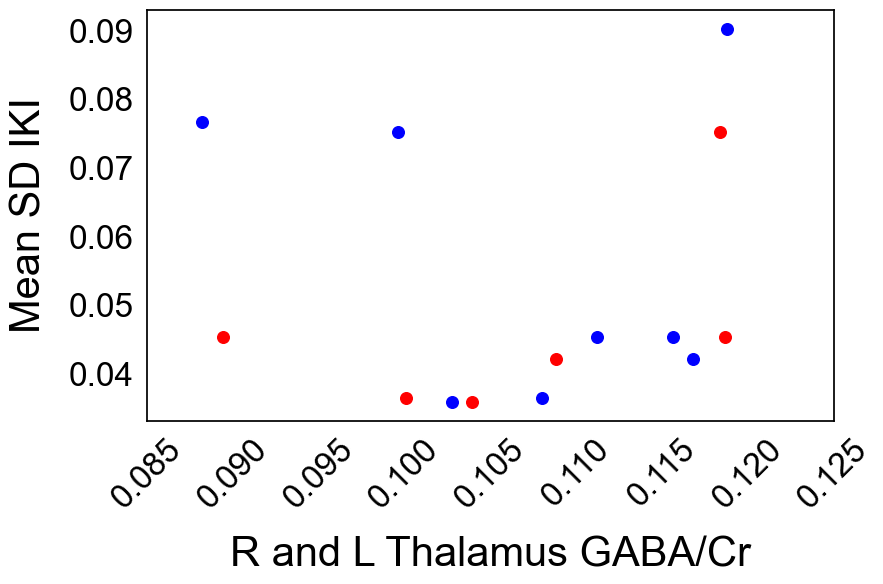

In [130]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300)
plt.show()

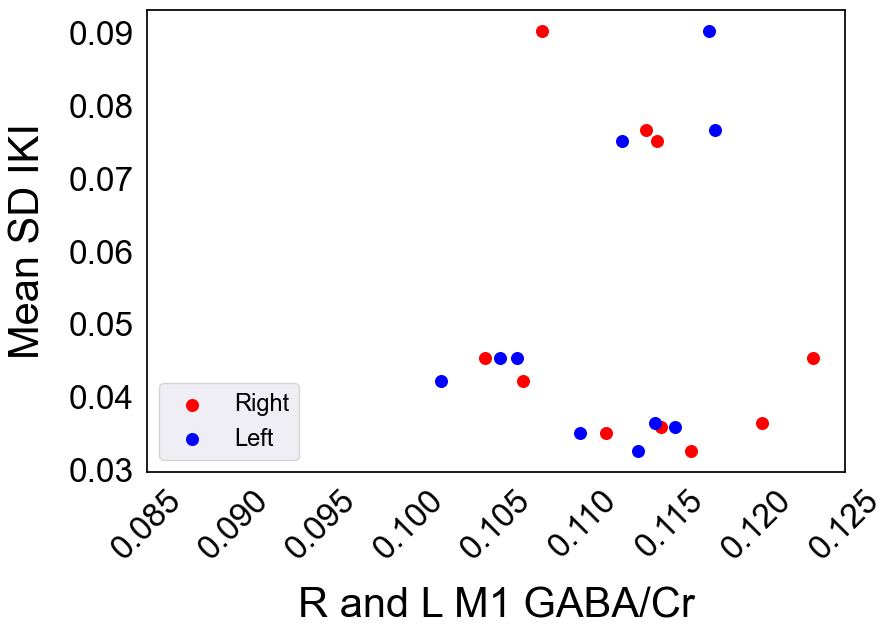

In [131]:
## all bf sds against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig('RLM1_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

NameError: name 'GABA_Lthal' is not defined

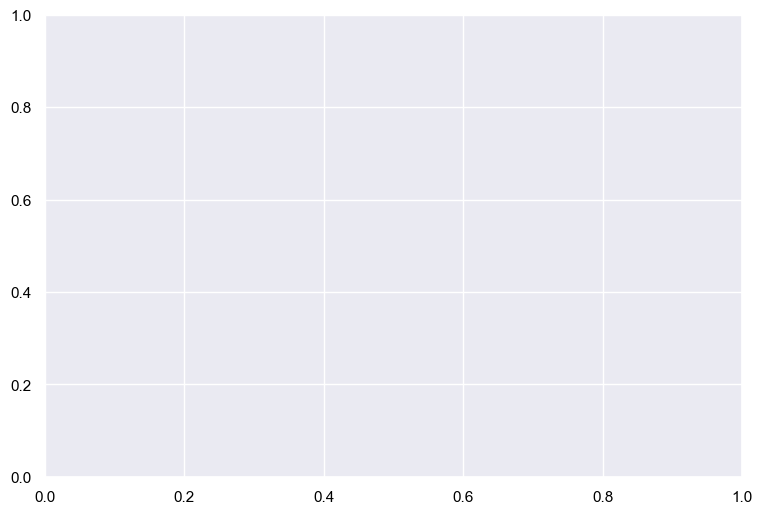

In [132]:
## highbf sds against L_thal GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI'], s = 70, color = 'black')
plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.savefig('Lthal_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## highbf sds against L_M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_sds['Avg SD IKI'], s = 70, color = 'black')
plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xlim([0.1, 0.12])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.savefig('LM1_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Graphs for F31

In [ ]:
ten_sub_list = ['s181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212']

ten_sub = corr_trials_bybg[corr_trials_bybg.sID.isin(ten_sub_list)].reset_index()

In [ ]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(ten_sub, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(ten_sub, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(ten_sub, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(ten_sub, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(ten_sub, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(ten_sub, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.4])
plt.xticks(x, ('', '', ''), fontsize = 24)
plt.xticks(x, ('Low', 'Med', 'High'))
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(ten_sub, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(ten_sub, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(ten_sub, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.10, 0.4])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean CV IKI (%)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(ten_sub, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(ten_sub, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(ten_sub, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(ten_sub, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(ten_sub, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(ten_sub, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.0, 0.10])
plt.xticks(x, ('', '', ''), fontsize = 24)
# plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
# plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean SD IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
incorr_ten_sub = incorr_bgs[incorr_bgs.sID.isin(ten_sub_list)].reset_index()

plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_ten_sub, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_ten_sub, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_ten_sub, 'bigram', typ.highbf)['Total Error'])

means = (np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.lowbf)['Total Error']), 
         np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.medbf)['Total Error']),
         np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.highbf)['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-1, 22])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Indiv. Total Error", labelpad=15, fontsize = 24)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_meanerr_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

violin = ax.violinplot(D, [2, 4, 6], showmeans= True)

for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# boxprops = dict(linestyle='-', linewidth=2, color = 'black')
# whiskerprops = dict(linewidth=2, color = 'black')
# capprops = dict(linewidth=2, color = 'black')
# flierprops = dict(markerfacecolor='royalblue', markersize=10)
# medianprops = dict(linewidth=2, color='red')

# ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
#           flierprops=flierprops, medianprops=medianprops)


plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.yaxis.offsetText.set_fontsize(18)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_bf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

In [ ]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(ten_sub, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(ten_sub, 'bigram', medbf_norep)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(ten_sub, 'bigram', lowbf_norep)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')